This is for gumbel_softmax.py, choose 1 graph out of 5

In [1]:
import re
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from torch_geometric.data import Data, DataLoader, DenseDataLoader as DenseLoader
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T
import networkx as nx

from gumbel_softmax import DiffPool


In [2]:
# load data
with open(r'./data/patient_gumbel3.pickle', 'rb') as handle:
        patient_dict= pickle.load(handle)
        
class PatientDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(PatientDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['patient.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        node_labels_dict = {'CD3p': 0, 'CD3p_CD4p': 1, 'CD8p_CD3p': 2, 'Tumor': 3, 'Stroma': 4}
#         node_labels_dict = {'TIL':0, 'Tumor': 1, 'Stroma': 2}
        class_num = len(node_labels_dict)
        
        for idx, v in enumerate(patient_dict.values()):
            for G in v:
                node_features = torch.LongTensor([node_labels_dict[i] for i in 
                                list(nx.get_node_attributes(G, 'cell_types').values())]).unsqueeze(1)
                x = torch.zeros(len(G.nodes), class_num).scatter_(1, node_features, 1)
                y = torch.LongTensor([idx])
                edges = sorted([e for e in G.edges] + [e[::-1] for e in G.edges])
                edge_index = torch.tensor([[e[0] for e in edges],
                                           [e[1] for e in edges]], dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

        
def get_dataset(path, sparse=False):
    
    dataset = PatientDataset(path)
    if not sparse:
        max_num_nodes = 0
        for data in dataset:
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        if dataset.transform is None:
            dataset.transform = T.ToDense(max_num_nodes)
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(max_num_nodes)])

    return dataset

dataset_dict = {}
path = './data/patient_gumbel3'
dataset_dict['gumbel5_1'] = get_dataset(path, sparse=False)

In [3]:
# save on gpu, load on cpu
# load model parameters 
def load_model(dir_path, params_name, m, num_patches=5, ratio=0.05, plot=True, ge=False, \
               total=20, hard=False, drop_lin2=True, decay_rate=1):
    device = torch.device('cpu')
    model = m(dataset, 5, 64, num_patches=num_patches, ratio=ratio, plot=plot, \
              ge=ge, total=total, hard=hard, decay_rate=decay_rate)
    params = torch.load(dir_path+params_name, map_location=device)
    # fix a problem that pre-training model contains lin2 (defined but not included in the computational graph) 
    if drop_lin2:
        params.pop('lin2.weight', None)
        params.pop('lin2.bias', None)
    model.load_state_dict(params)
    return model


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def cal_cfm_LogSoftmax_z(model, loader, initial_temp=0.5, total=20):
        
    model.eval()
    matrix = []
    matrix_hard = []
    Z = []
    y_true = []
    y_pred = []
    y_pred_hard = []
    logits = []
    
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            (out, out_hard), z, q_y = model(data, initial_temp)
            matrix.append(out.numpy())
            matrix_hard.append(out_hard.numpy())
            Z.append(z.numpy())
            logits.append(q_y.numpy())
            
            pred, pred_hard = out.max(1)[1], out_hard.max(1)[1]
            y_pred += pred.tolist() 
            y_pred_hard += pred_hard.tolist()
            
            len_ = len(data.y)
            indices = [i for i in range(0, len_, total)]
            y_true += data.y[indices].view(-1).tolist()
       
    matrix, matrix_hard = np.concatenate(matrix), np.concatenate(matrix_hard)
    
    
    Z, logits = np.concatenate(Z), np.concatenate(logits)
    cfm, cfm_hard = confusion_matrix(y_true, y_pred), confusion_matrix(y_true, y_pred_hard)
    return (cfm, cfm_hard), (matrix, matrix_hard), Z, logits

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def cal_cfm_LogSoftmax_z(model, loader, initial_temp=0.5, total=20):
#     model.eval()
#     matrix = []
#     Z = []
#     y_true = []
#     y_pred = []
    
#     for data in loader:
#         data = data.to(device)
#         with torch.no_grad():
#             out, _, z = model(data, initial_temp)
#             matrix.append(out.numpy())
#             Z.append(z.numpy())
#             pred = out.max(1)[1]
#             y_pred += pred.tolist()
#             len_ = len(data.y)
#             indices = [i for i in range(0, len_, total)]
#             y_true += data.y[indices].view(-1).tolist()
            
#     matrix = np.concatenate(matrix)
#     Z = np.concatenate(Z)
#     return confusion_matrix(y_true, y_pred), matrix, Z


    

In [6]:
def plot_cfm_LogSoftmax(cfm, matrix, title):
    sns.set(font_scale=1.3)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
    plt.suptitle(title, fontsize=14)
    
    df_cm = pd.DataFrame(cfm, range(1, cfm.shape[0]+1), range(1, cfm.shape[0]+1))
    sns.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')
    ax1.set_title('confusion matrix')
    
    ax2.imshow(matrix, cmap=cm.Blues, extent=[0.5, 10.5, 10.5, 0.5])
    ax2.set_xticks([i for i in range(1, 11)])
    ax2.set_yticks([i for i in range(1, 11)])
    ax2.set_xlabel('Predicted label')
    ax2.set_ylabel('True label')
    ax2.set_title('softmax values')
    
    plt.show()
    
    
# def plot_cfm_LogSoftmax2(cfm, matrix, cfm_hard, matrix_hard, title):
#     sns.set(font_scale=1.3)
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 4))
#     plt.suptitle(title, fontsize=14)
    
#     df_cm = pd.DataFrame(cfm, range(1, cfm.shape[0]+1), range(1, cfm.shape[0]+1))
#     sns.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, ax=ax1)
#     ax1.set_xlabel('Predicted label')
#     ax1.set_ylabel('True label')
#     ax1.set_title('confusion matrix, soft')
    
#     ax2.imshow(matrix, cmap=cm.Blues, extent=[0.5, 10.5, 10.5, 0.5])
#     ax2.set_xticks([i for i in range(1, 11)])
#     ax2.set_yticks([i for i in range(1, 11)])
#     ax2.set_xlabel('Predicted label')
#     ax2.set_ylabel('True label')
#     ax2.set_title('softmax values, soft')
    
#     df_cm_hard = pd.DataFrame(cfm_hard, range(1, cfm_hard.shape[0]+1), range(1, cfm_hard.shape[0]+1))
#     sns.heatmap(df_cm_hard, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, ax=ax3)
#     ax3.set_xlabel('Predicted label')
#     ax3.set_ylabel('True label')
#     ax3.set_title('confusion matrix, hard')
    
#     ax4.imshow(matrix_hard, cmap=cm.Blues, extent=[0.5, 10.5, 10.5, 0.5])
#     ax4.set_xticks([i for i in range(1, 11)])
#     ax4.set_yticks([i for i in range(1, 11)])
#     ax4.set_xlabel('Predicted label')
#     ax4.set_ylabel('True label')
#     ax4.set_title('softmax values, hard')

In [7]:
def plot_loss_acc(filename):
    with open(filename) as f:
        contents = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    dic = {}
    for line in contents:
        if "Num" in line:
            param = line.strip()
            dic[param] = [[], []]
        if "Train Loss" in line:
            loss = float(re.findall("Train Loss: ([0-9.]+)", line)[0])
            acc = float(re.findall("Train Accuracy: ([0-9.]+)", line)[0])
            dic[param][0].append(loss)
            dic[param][1].append(acc)
    
    for key, val in dic.items():
        fig, (ax_loss, ax_acc) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 12))
        ax_loss.set_title("Loss")
        length = len(val[0])
        # plot mean loss
        ax_loss.plot(range(1, length+1), val[0])

        ax_acc.set_title("Accuracy")
        length = len(val[1])
        ax_acc.plot(range(1, length+1), val[1])


In [8]:
def shuffle(dataset, m=20):
    random.seed(123)
    indices = []
    for i in range(10):
        tmp = [j for j in range(i*m, i*m+m)]
        random.shuffle(tmp)
        indices += tmp
    return indices

In [9]:
def plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, epochs, ratio=0.05, \
                   num_patches=1, plot=True, ge=False, total=10, hard=False):
    output = []
    output2 = []
    cfms, cfms_hard, matrices, matrices_hard = [], [], [], []
    temp_list = [np.maximum(initial_temp * np.exp(-annealing_rate * iteration), lower_bound) \
             for iteration in [e-1 if idx!=0 else e for idx, e in enumerate(epochs)]]
    for j, epoch in enumerate(epochs):
        params_name = 'params_epoch{}.pt'.format(epoch)
        model = load_model(dir_path, params_name, DiffPool, ratio=ratio, num_patches=num_patches, \
                           plot=plot, ge=ge, total=total, hard=hard)
        (cfm, cfm_hard), (matrix, matrix_hard), Z, logits = cal_cfm_LogSoftmax_z(model, data_loader, \
                                                initial_temp=temp_list[j], total=total)
        output.append(Z)
        output2.append(logits)
        cfms.append(cfm)
        cfms_hard.append(cfm_hard)
        matrices.append(matrix)
        matrices_hard.append(matrix_hard)
        plot_cfm_LogSoftmax(cfm, matrix, 'epoch{}, soft'.format(epoch))
        plot_cfm_LogSoftmax(cfm_hard, matrix_hard, 'epoch{}, hard'.format(epoch))
    output, output2 = np.concatenate(output), np.concatenate(output2)
    return output, output2, cfms, cfms_hard, matrices, matrices_hard


def plot_Z(epochs, output, total):
    for idx, epoch in enumerate(epochs):
        fig, axes = plt.subplots(10, 2, figsize=(11, 18))
        start = idx*10 
        plt.suptitle('epoch{}'.format(epoch), x=0.5, y=0.9)
        for i in range(10):
            axes[i, 0].imshow(output[start+i], cmap=cm.Blues, extent=[0.5, total+0.5, 1.5, 0.5])
            set_ = indices[i*total:i*total+total]
            anchor_x = set_.index(max(set_)) + 0.5
            rect = patches.Rectangle((anchor_x,0.5),1,1,linewidth=2.5,edgecolor='r',facecolor='none')
            axes[i, 0].add_patch(rect)
            axes[i, 0].set_xticks([i for i in range(1, total+1)])
            axes[i, 0].set_yticks([i for i in range(1, 2)])
            axes[i, 0].set_title('Patient {:0>4d}'.format(i+1))
            
            one_hot = np.zeros_like(output[start+i])
            one_hot[0, np.argmax(output[start+i])] = 1
            axes[i, 1].imshow(one_hot, cmap=cm.Blues, extent=[0.5, total+0.5, 1.5, 0.5])
            rect = patches.Rectangle((anchor_x,0.5),1,1,linewidth=2.5,edgecolor='r',facecolor='none')
            axes[i, 1].add_patch(rect)
            axes[i, 1].set_xticks([i for i in range(1, total+1)])
            axes[i, 1].set_yticks([i for i in range(1, 2)])


In [11]:
batch_size = 50
total = 5

initial_temp = 10
annealing_rate = 0.01
lower_bound = 0.5

dataset = dataset_dict['gumbel5_1']
indices = shuffle(dataset, m=total)
dataset = dataset[indices]
data_loader = DenseLoader(dataset, batch_size, shuffle=False)

## Without pretraining

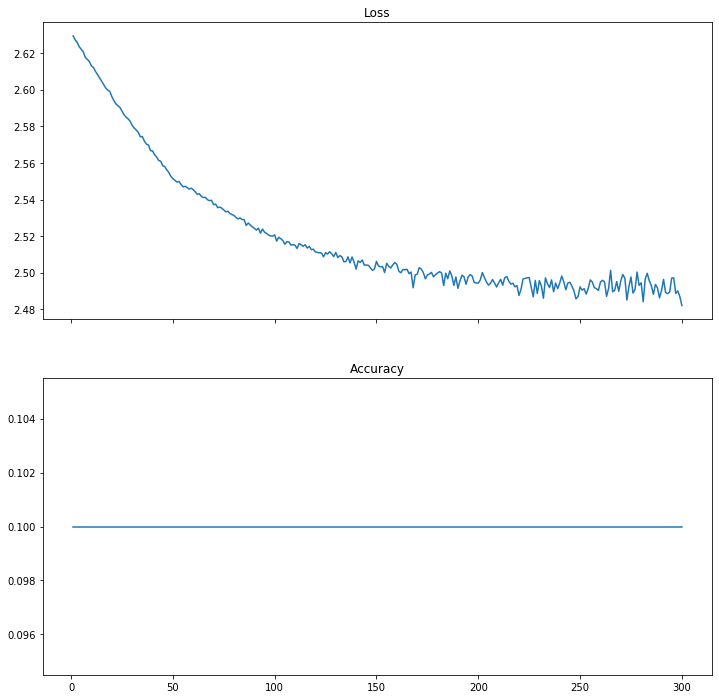

In [12]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-soft2/'
plot_loss_acc(dir_path+'log_2020-11-12_12-16.txt')
# plt.savefig('./img/g151.png', dpi=300)

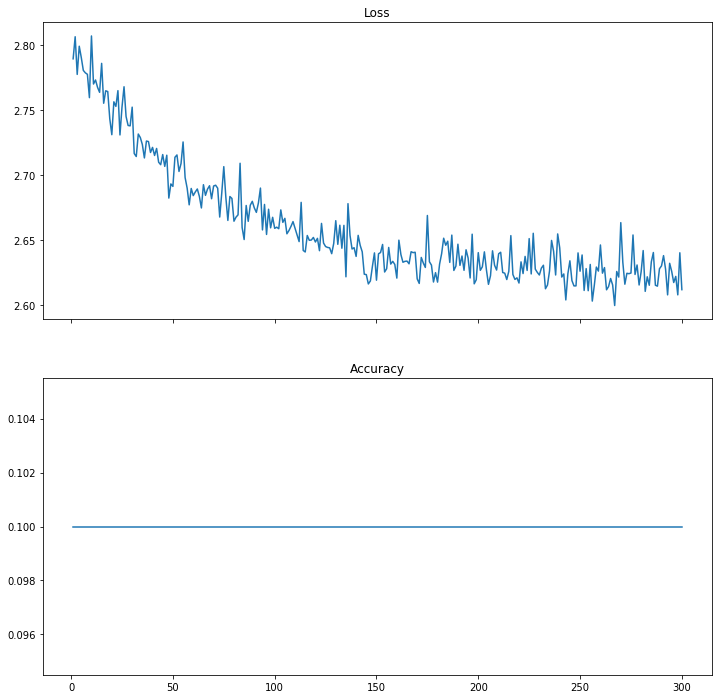

In [13]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-hard2/'
plot_loss_acc(dir_path+'log_2020-11-12_12-20.txt')
# plt.savefig('./img/g152.png', dpi=300)

## Pretrained graph embedding (average), joint learning

## soft

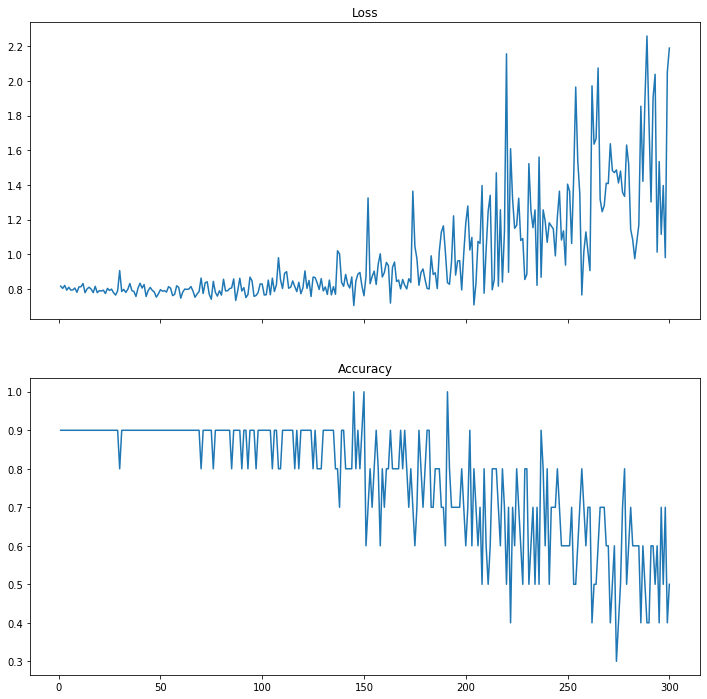

In [12]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-avg/'
plot_loss_acc(dir_path+'log_2020-10-30_09-02.txt')
# plt.savefig('./img/g1531.png', dpi=300)

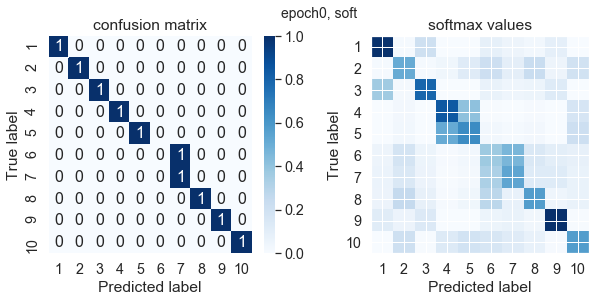

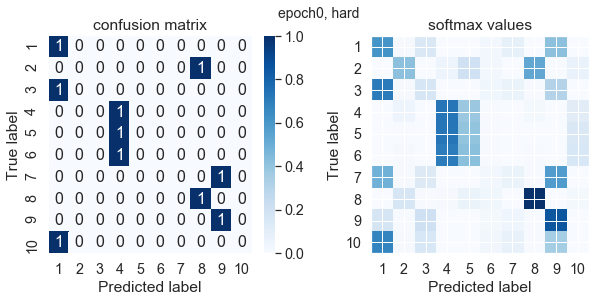

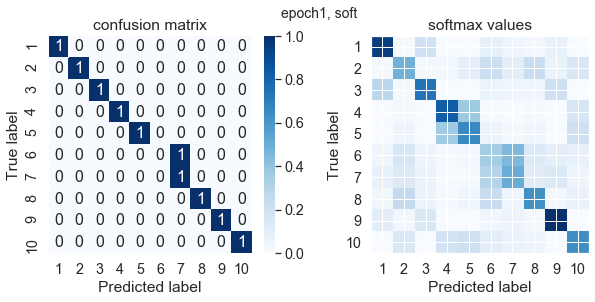

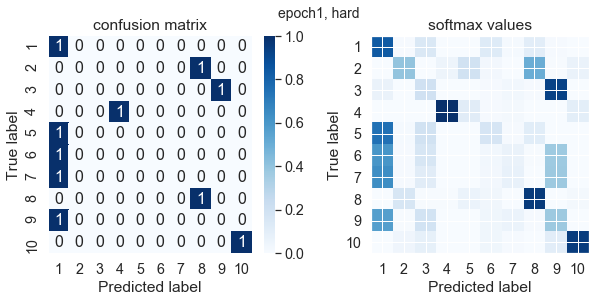

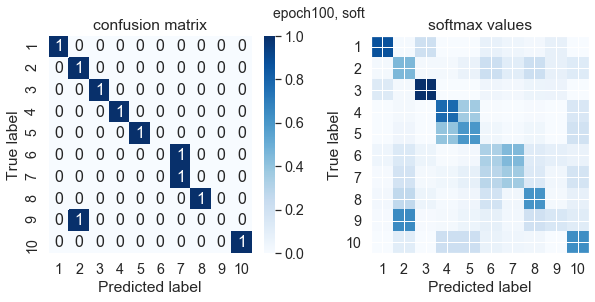

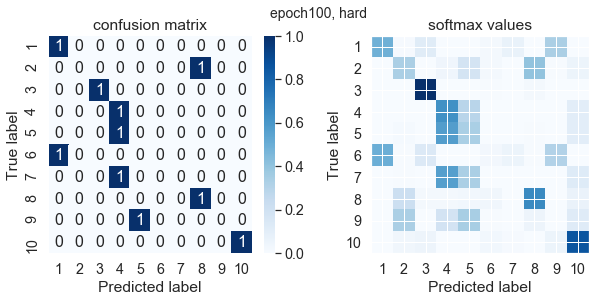

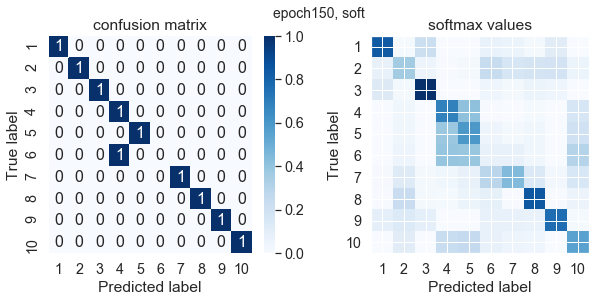

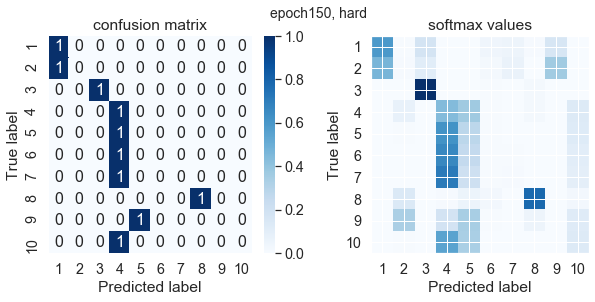

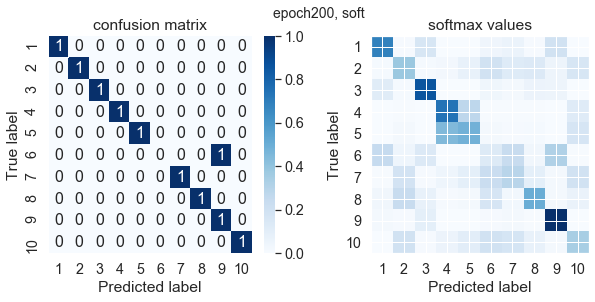

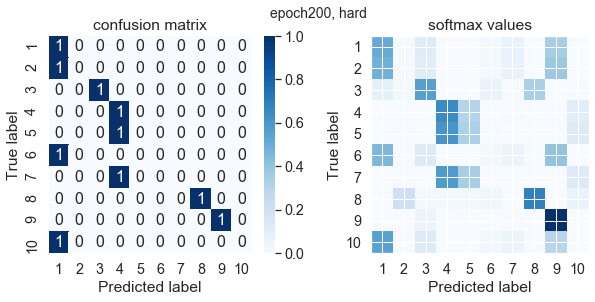

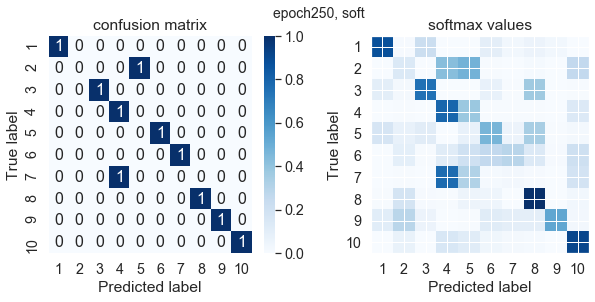

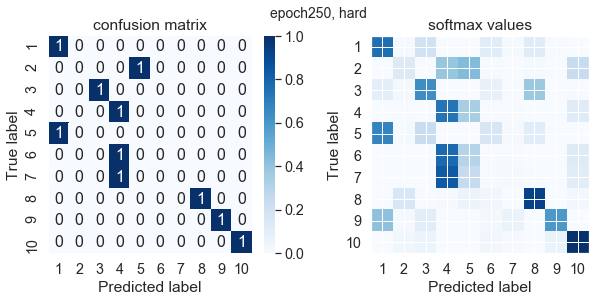

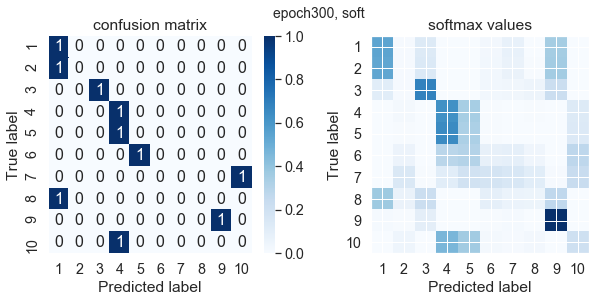

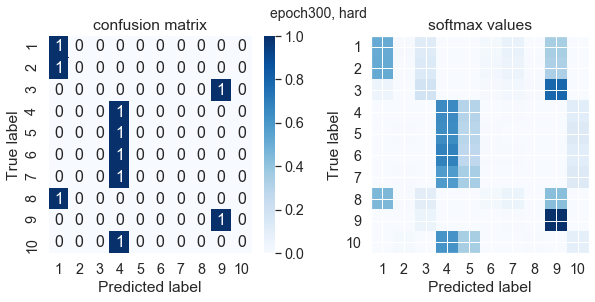

In [12]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-avg/'
output, output2, cfms, cfms_hard, matrices, matrices_hard = \
plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, [0, 1, 100, 150, 200, 250, 300], \
               ratio=0.05, num_patches=1, plot=True, ge=False, total=total, hard=True)

result = [output, output2, cfms, cfms_hard, matrices, matrices_hard]

# with open(dir_path+'result_repro.pickle', 'wb') as handle:
#     pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

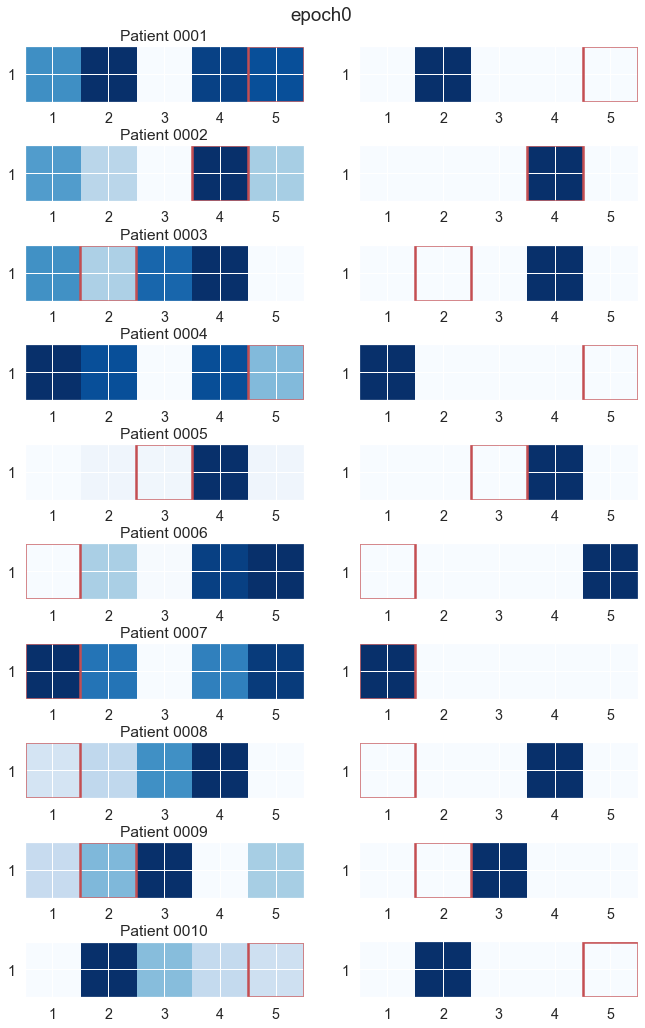

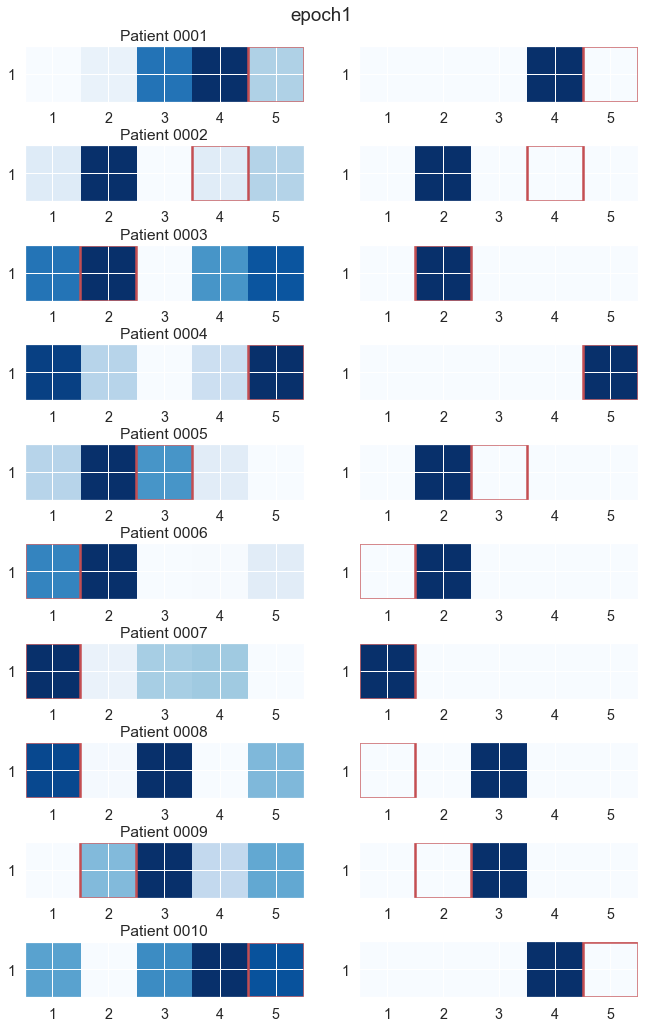

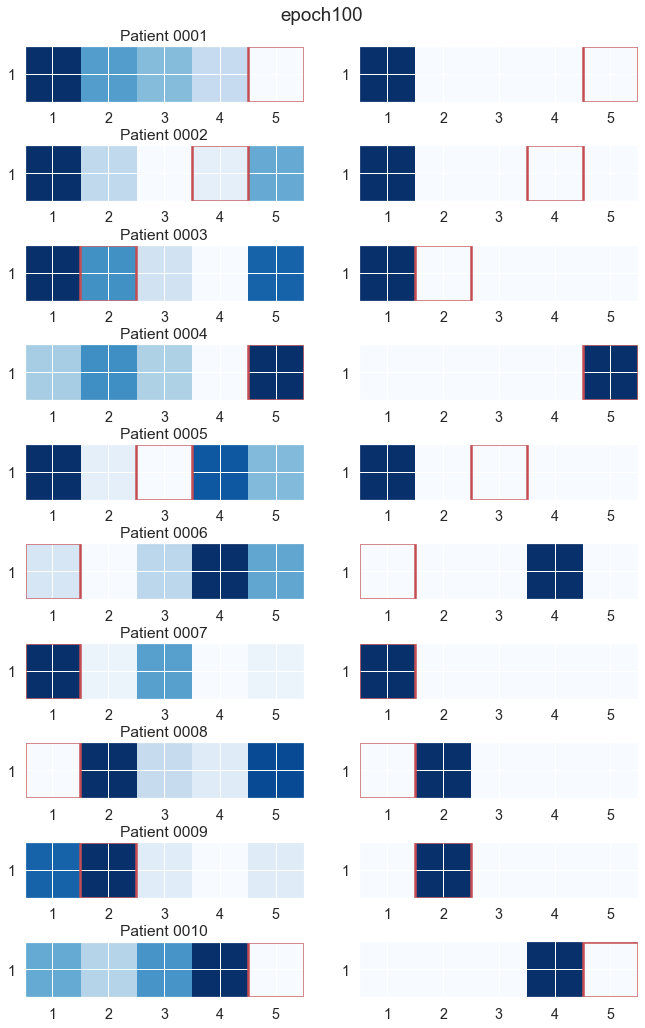

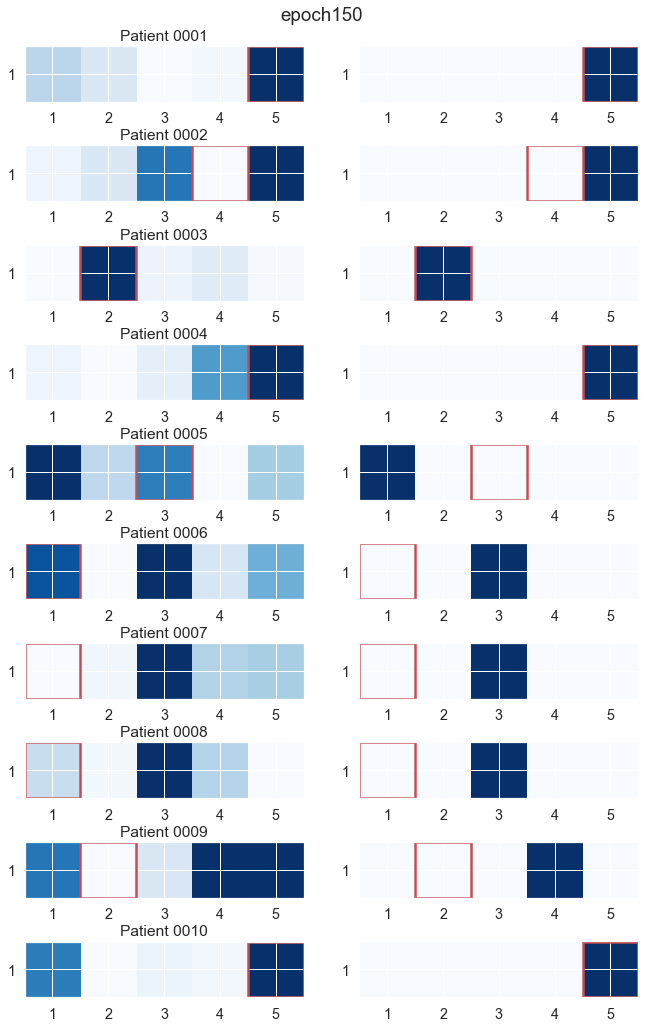

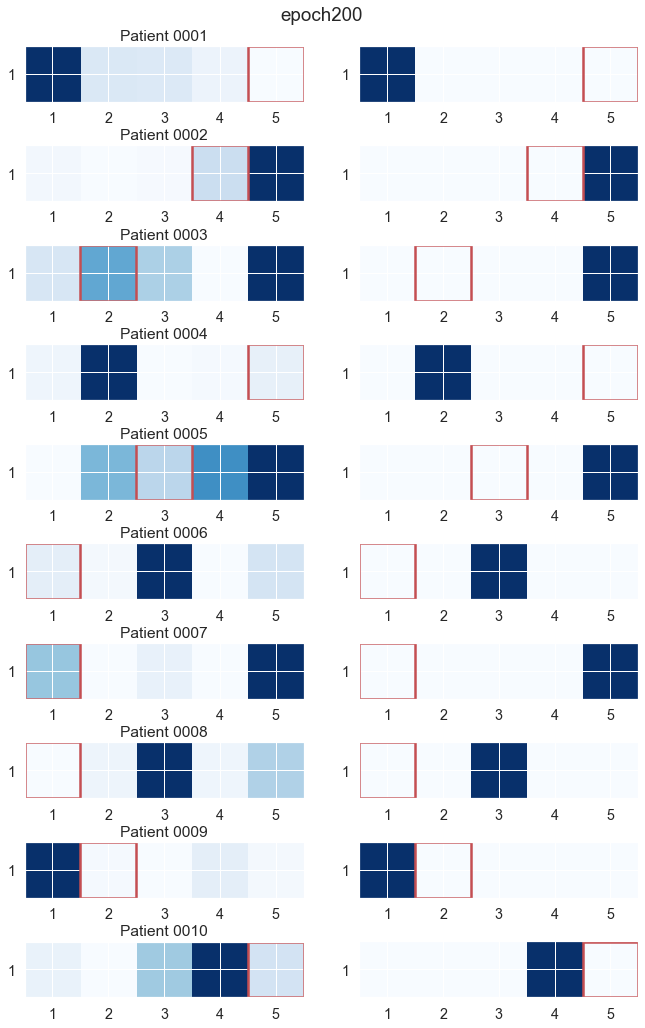

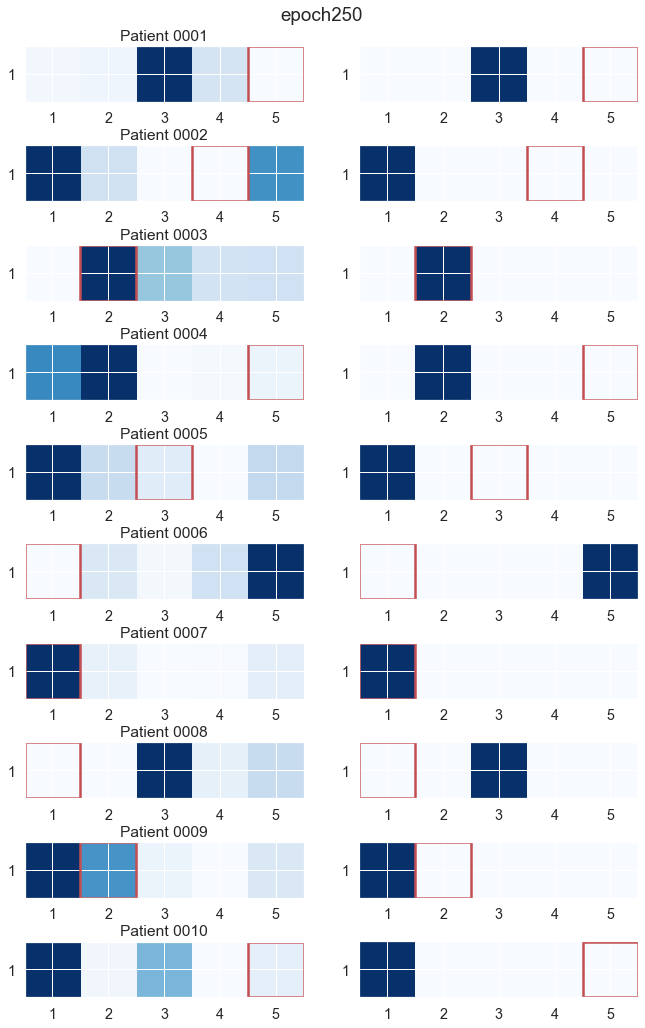

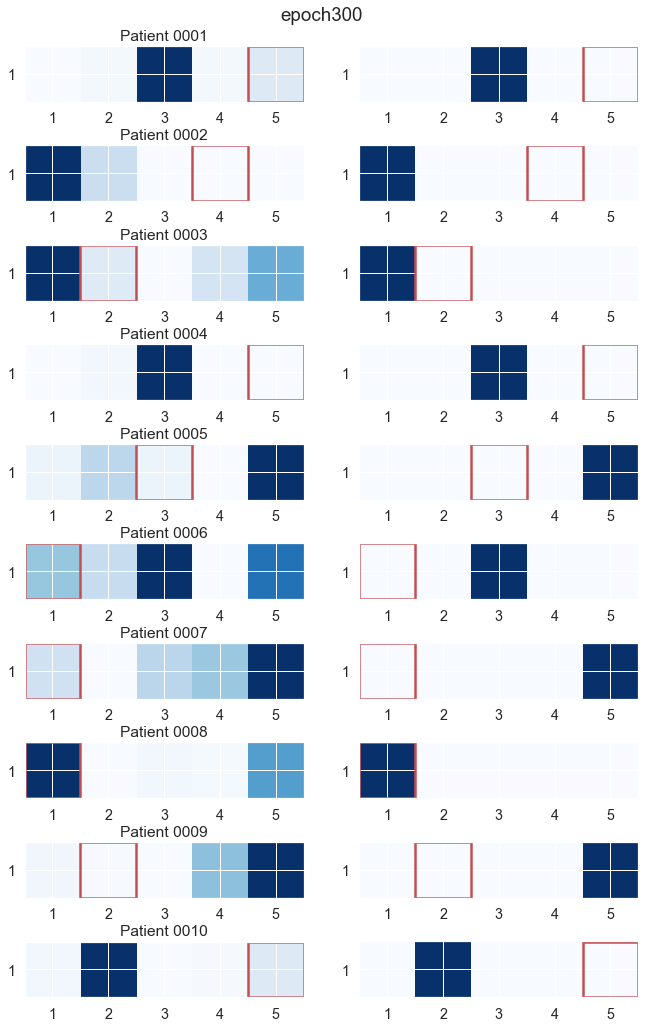

In [24]:
# plot Z
plot_Z([0, 1, 100, 150, 200, 250, 300], output, total)

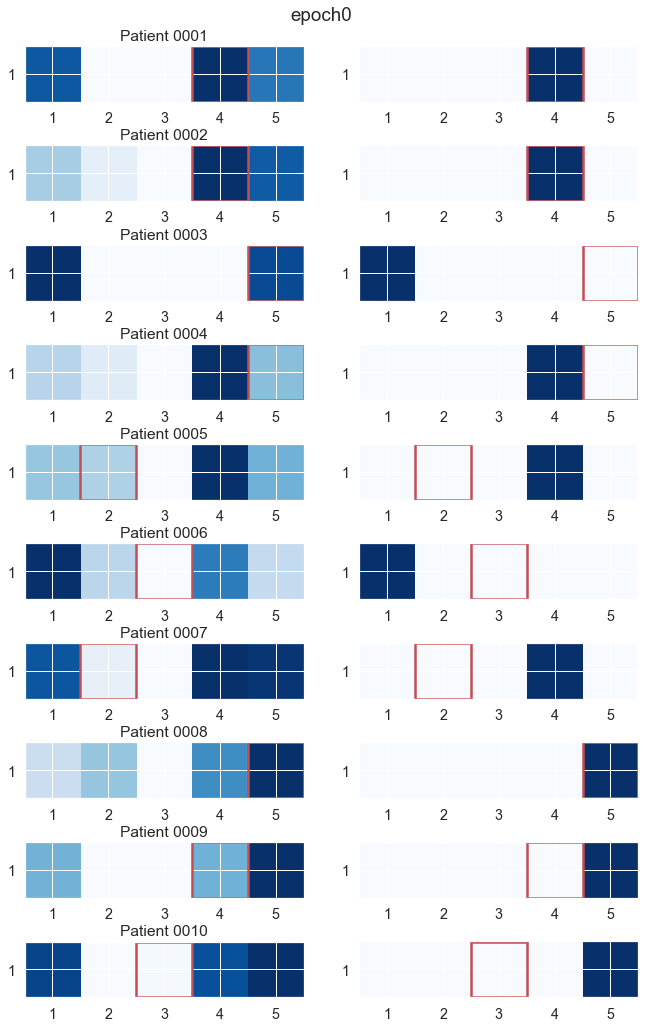

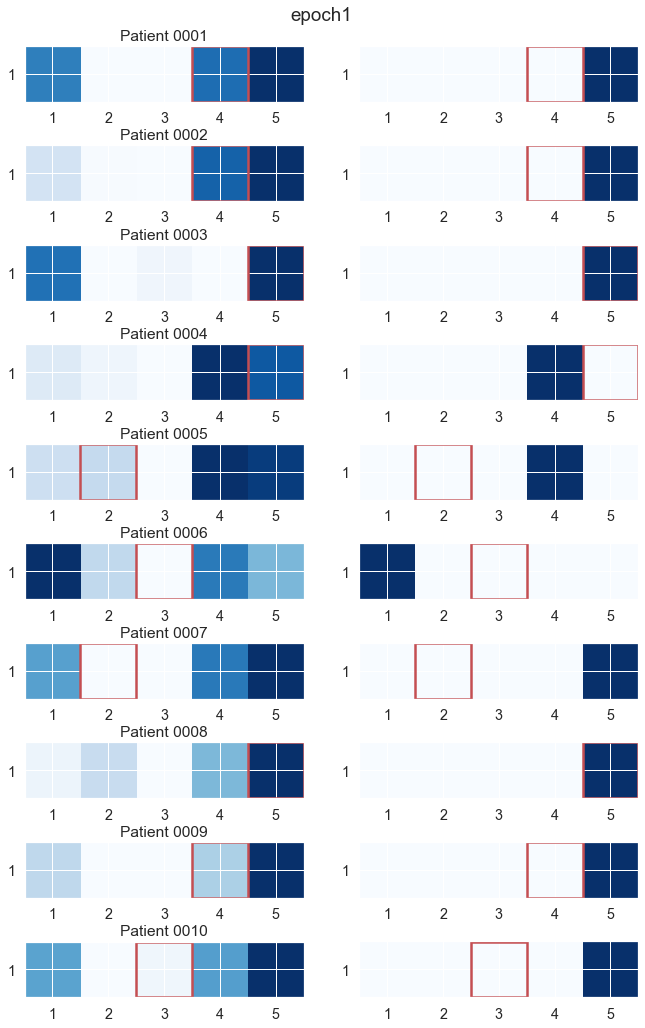

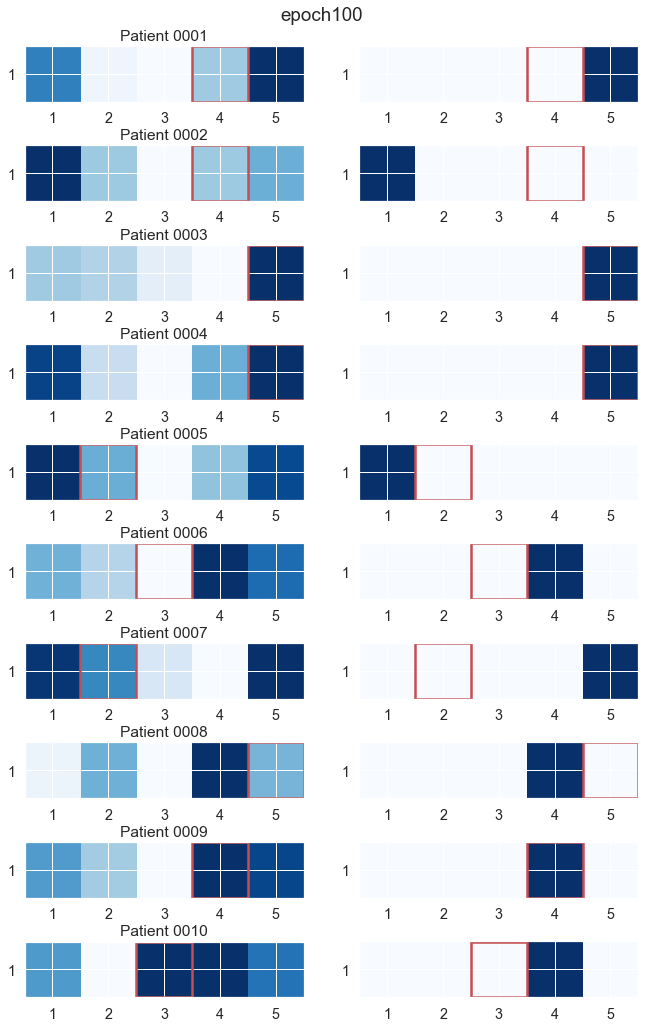

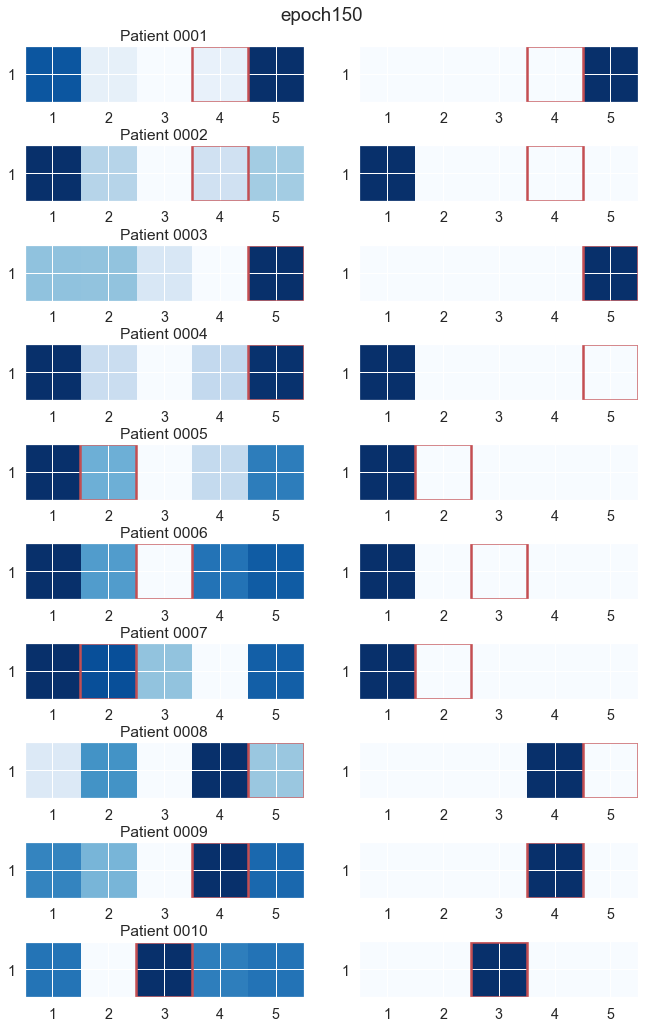

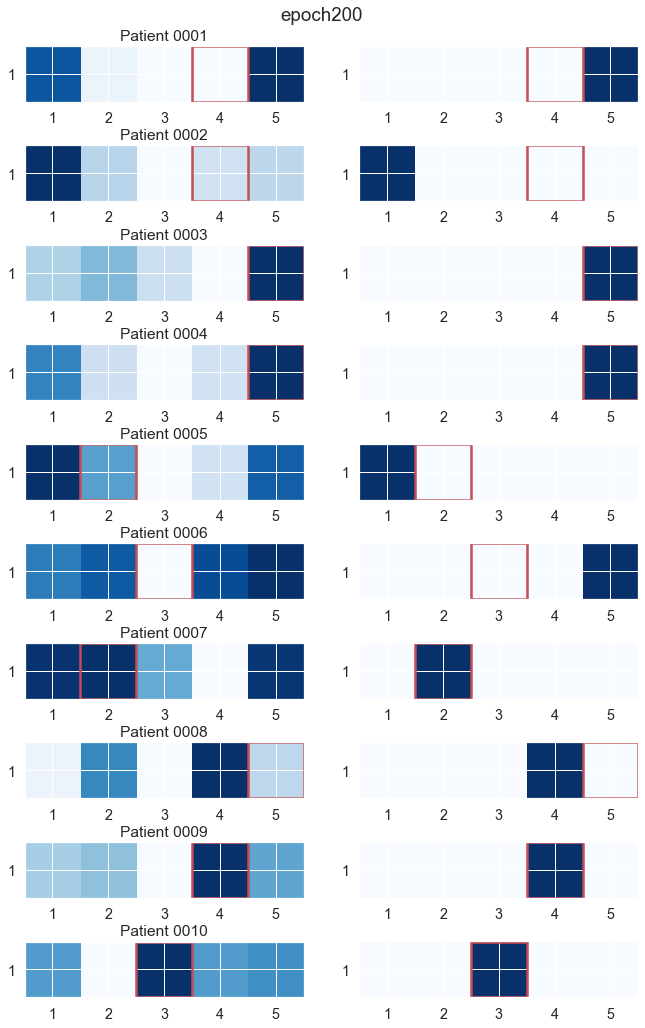

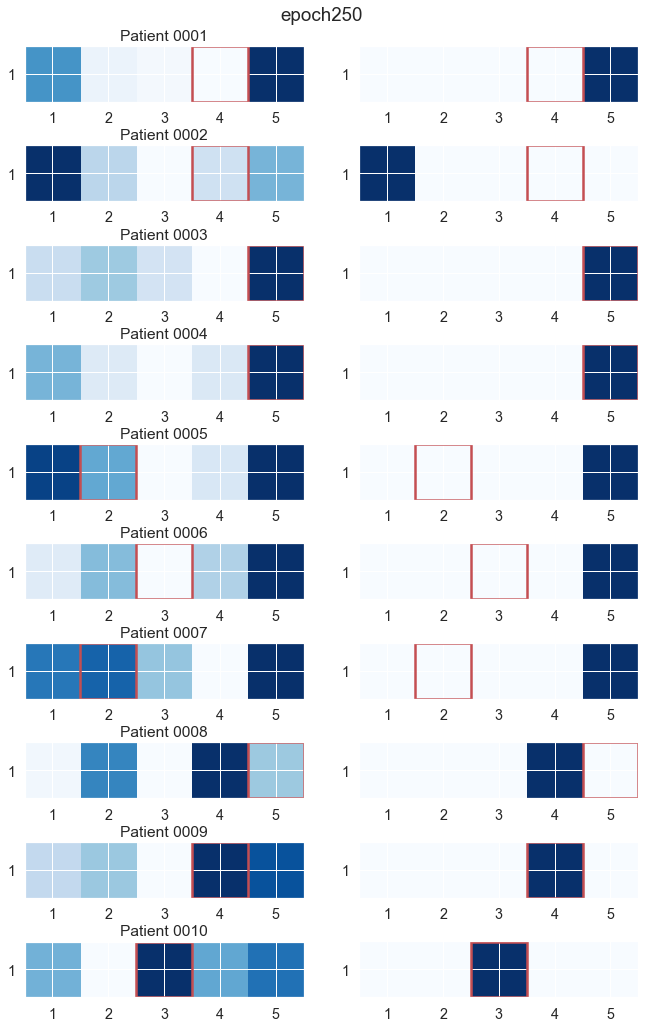

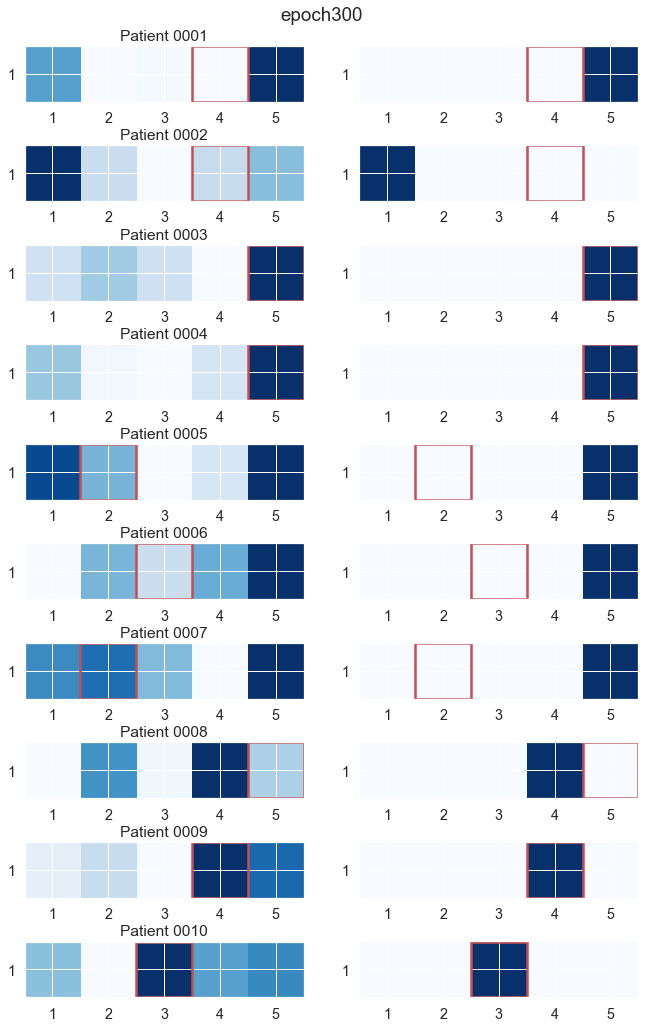

In [15]:
# plot logits
plot_Z([0, 1, 100, 150, 200, 250, 300], output2, total)

## hard

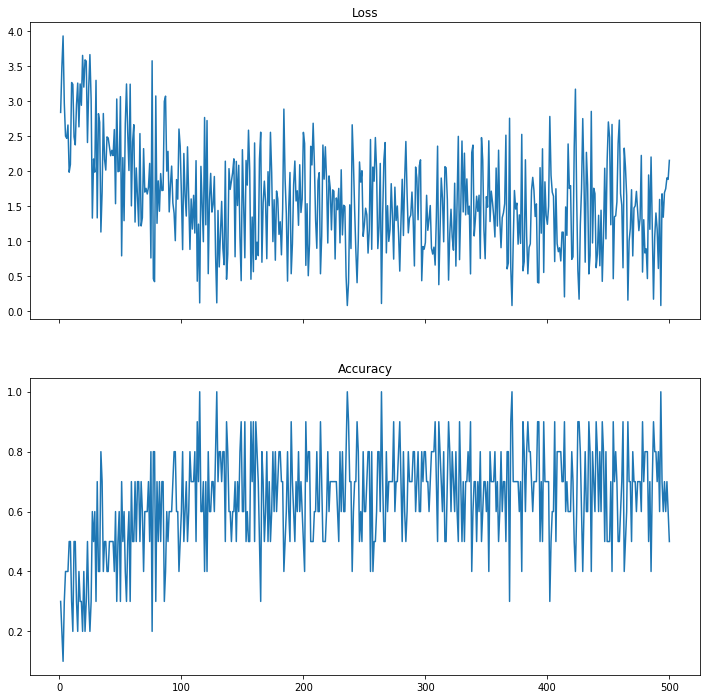

In [17]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-avg-hard/'
plot_loss_acc(dir_path+'log_2020-11-12_16-46.txt')
# plt.savefig('./img/g1541.png', dpi=300)

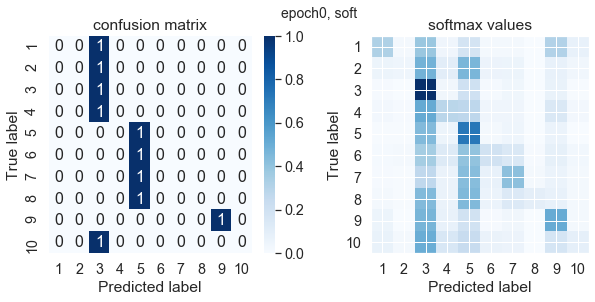

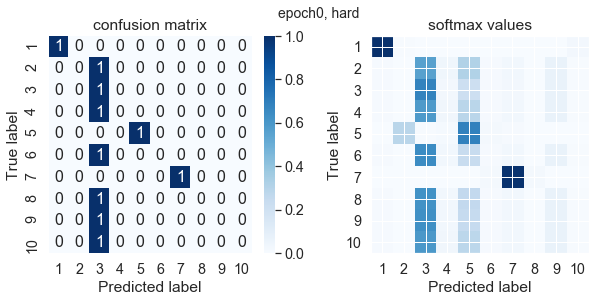

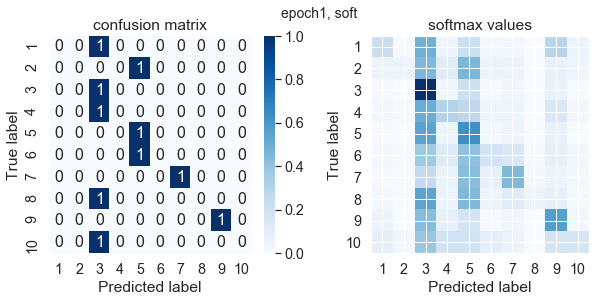

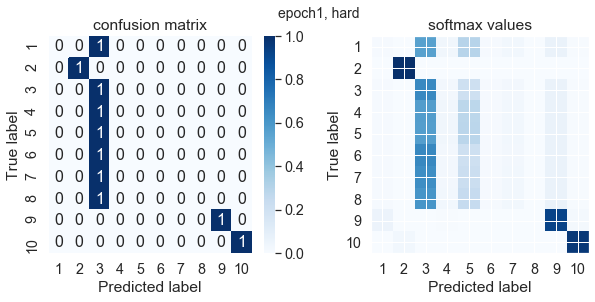

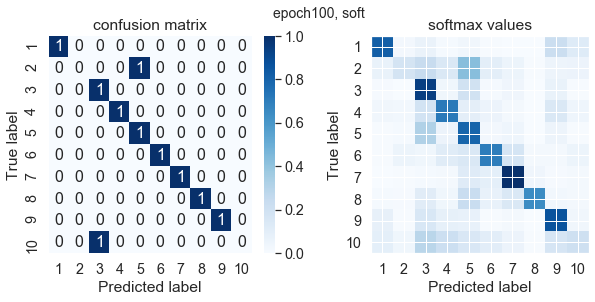

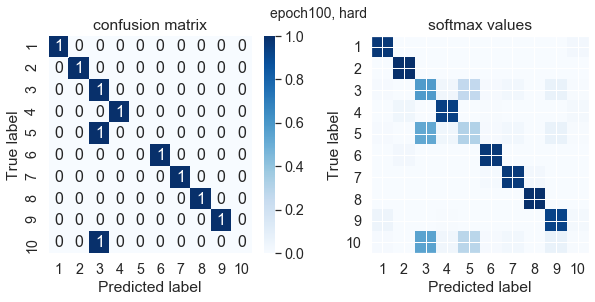

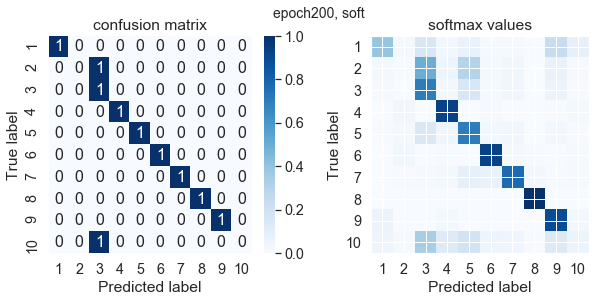

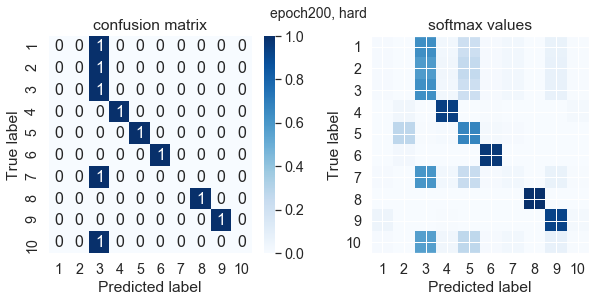

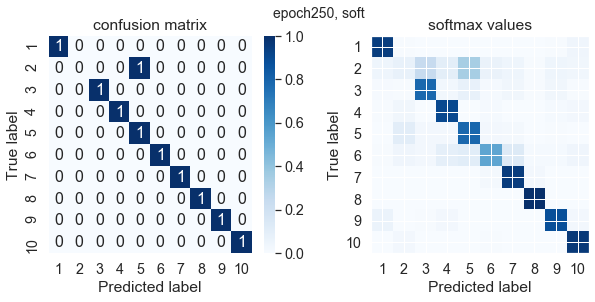

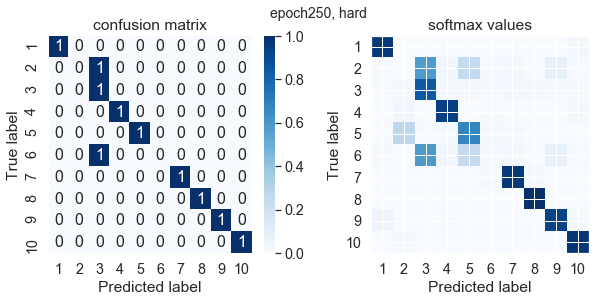

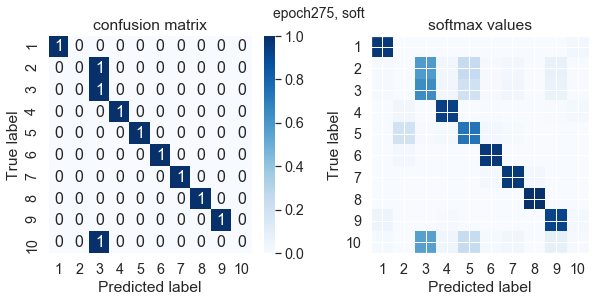

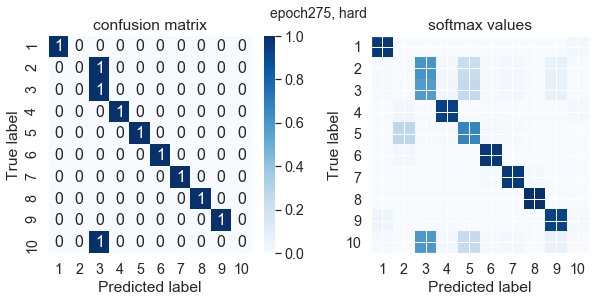

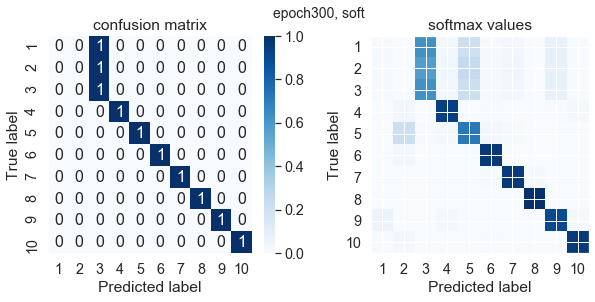

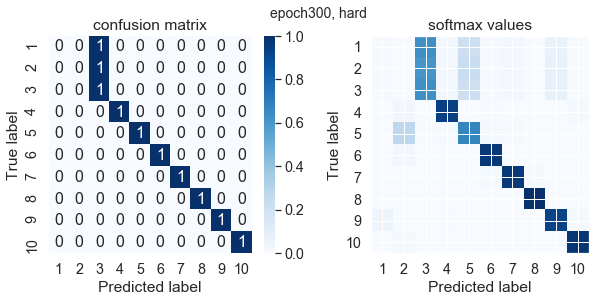

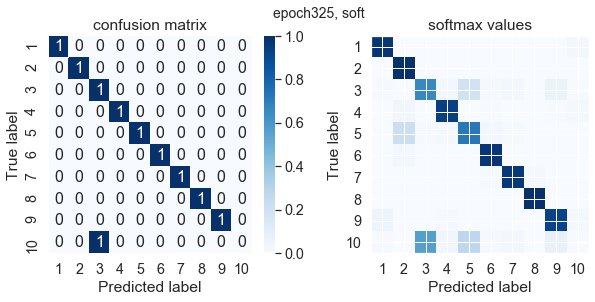

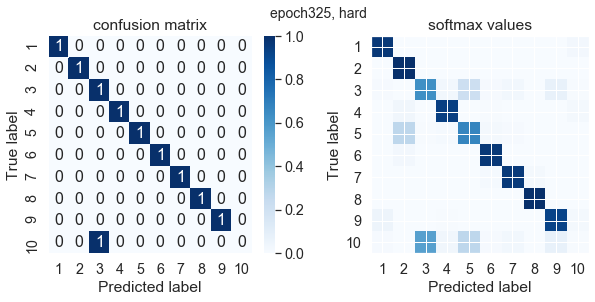

In [14]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-avg-hard/'
output, output2, cfms, cfms_hard, matrices, matrices_hard = \
plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, [0, 1, 100, 200, 250, 275, 300, 325], \
               ratio=0.05, num_patches=1, plot=True, ge=False, total=total, hard=True)

result = [output, output2, cfms, cfms_hard, matrices, matrices_hard]

# with open(dir_path+'result_repro.pickle', 'wb') as handle:
#     pickle.dump((indices, result), handle, protocol=pickle.HIGHEST_PROTOCOL)

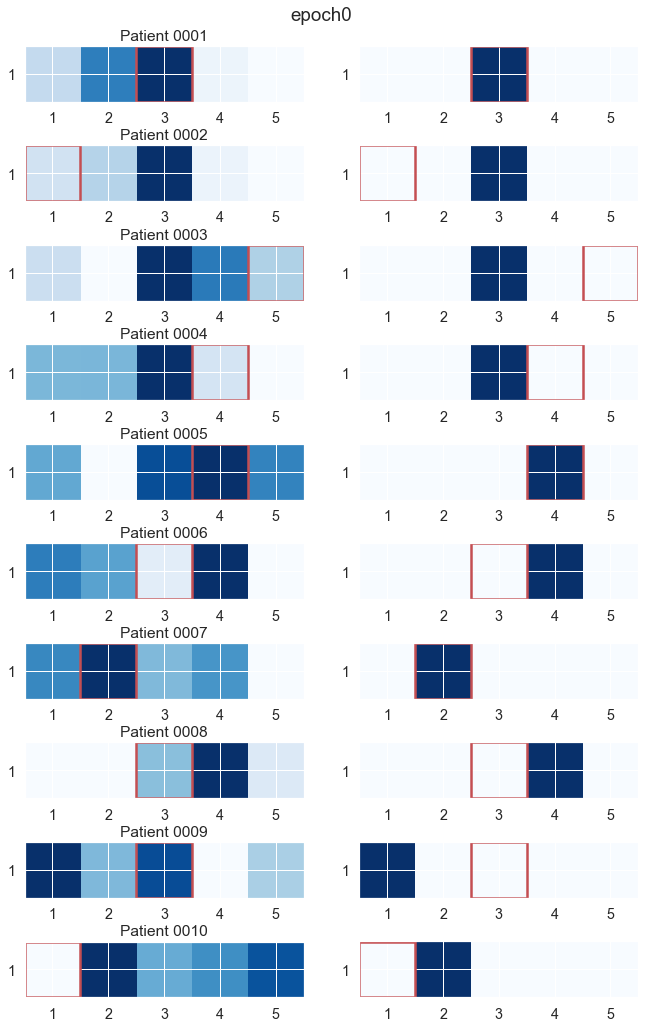

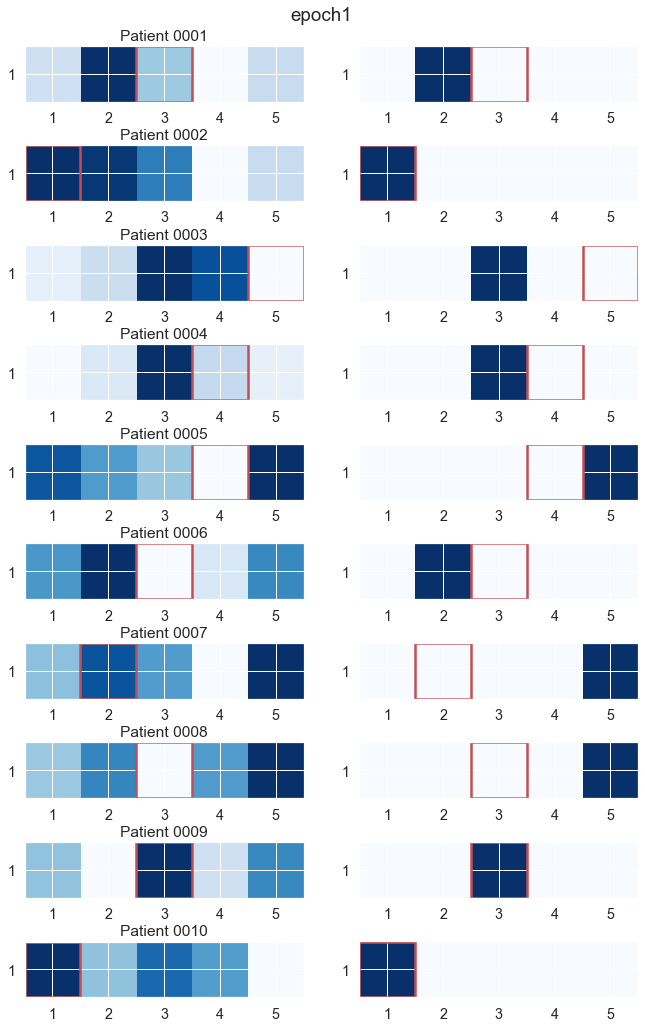

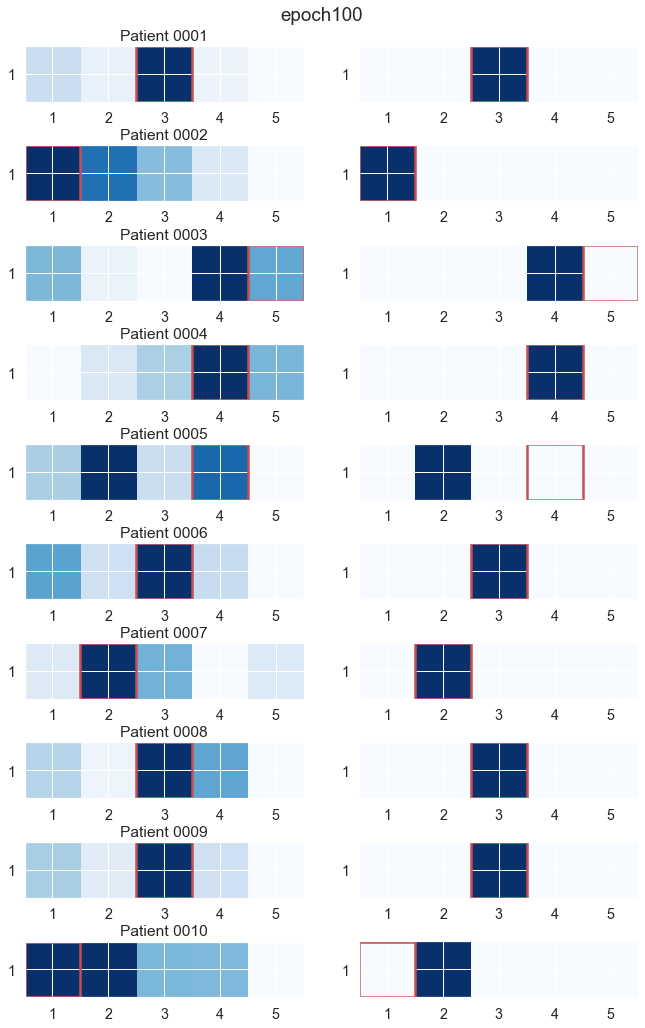

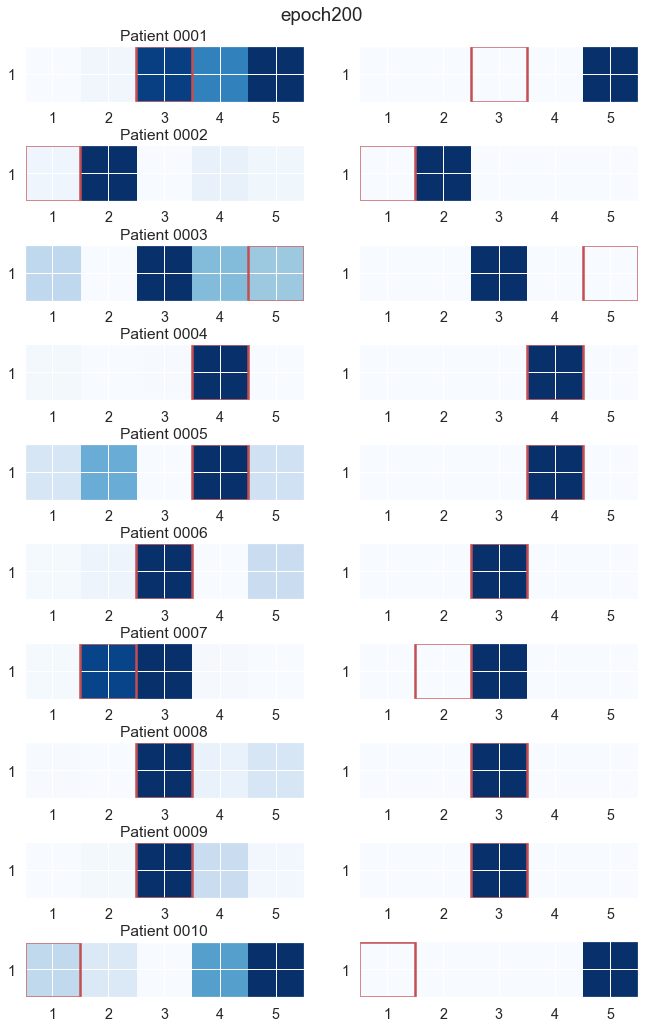

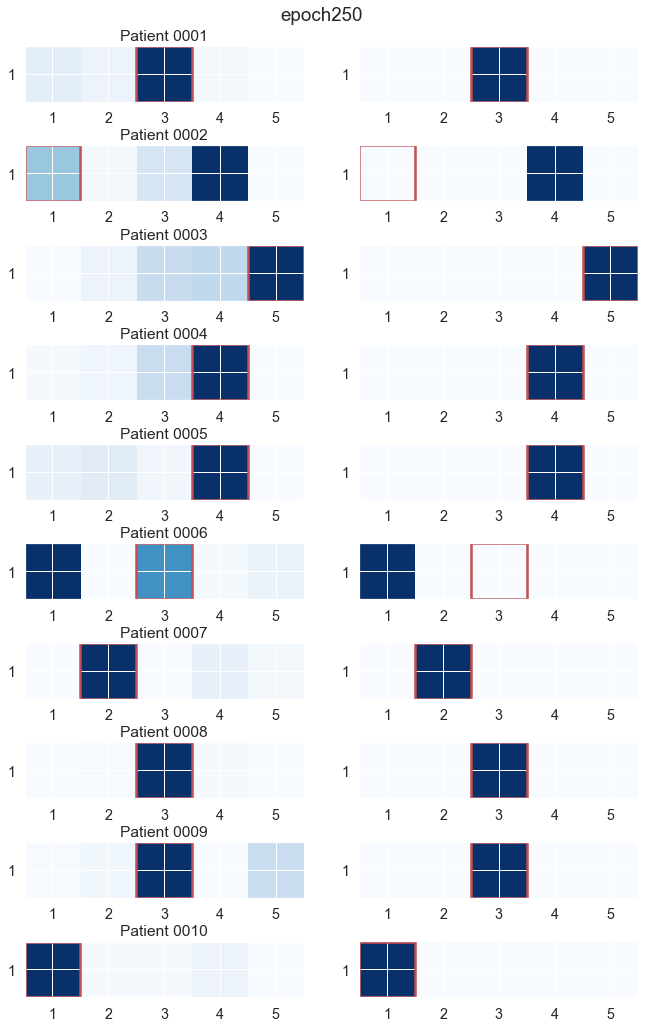

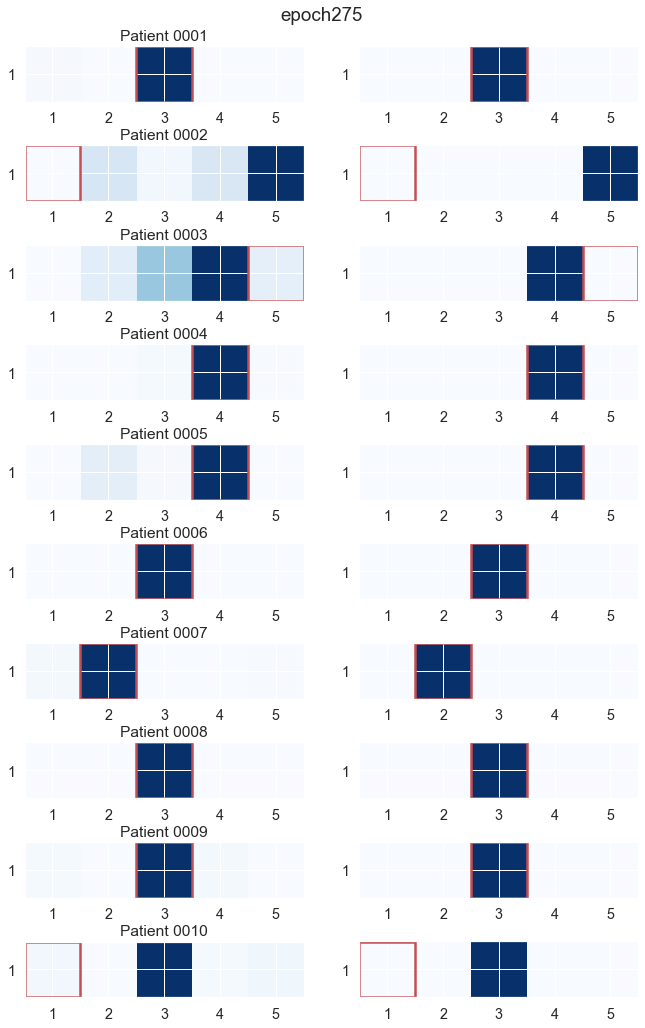

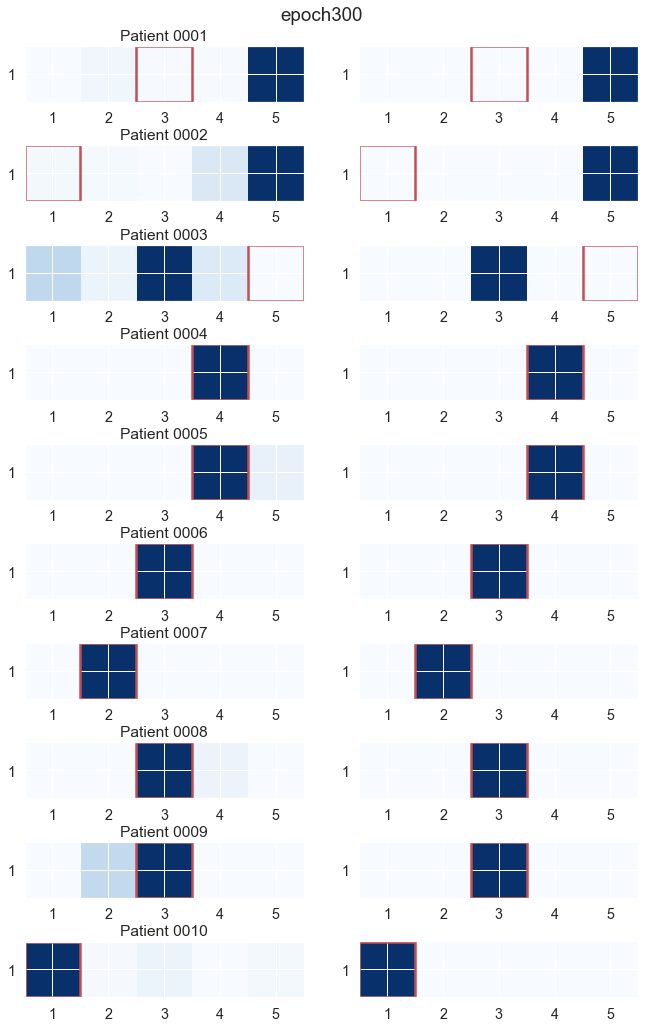

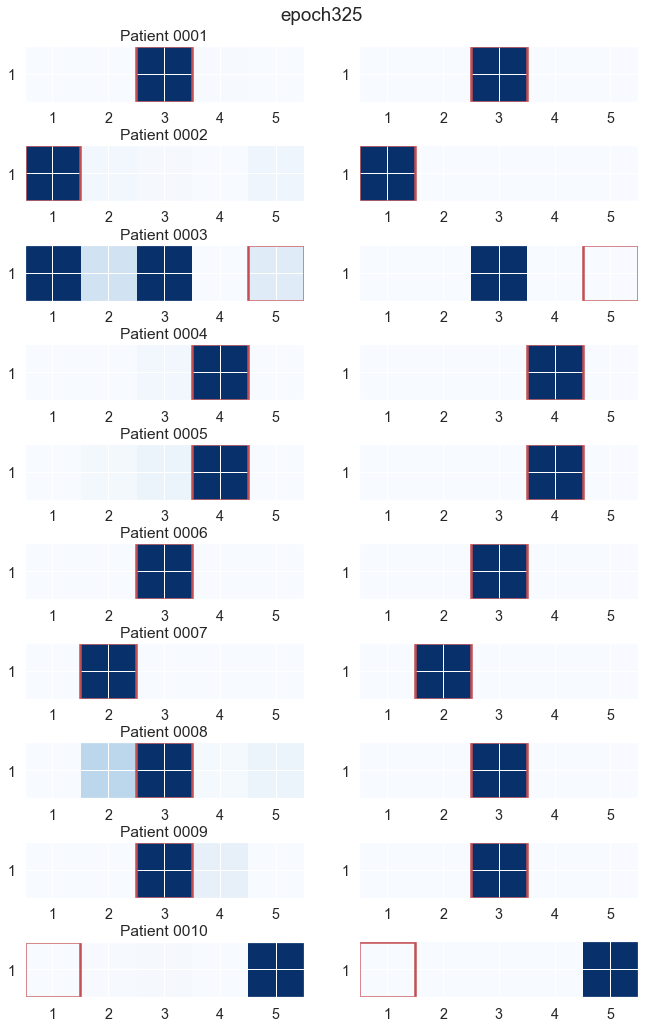

In [15]:
# plot Z
plot_Z([0, 1, 100, 200, 250, 275, 300, 325], output, total)

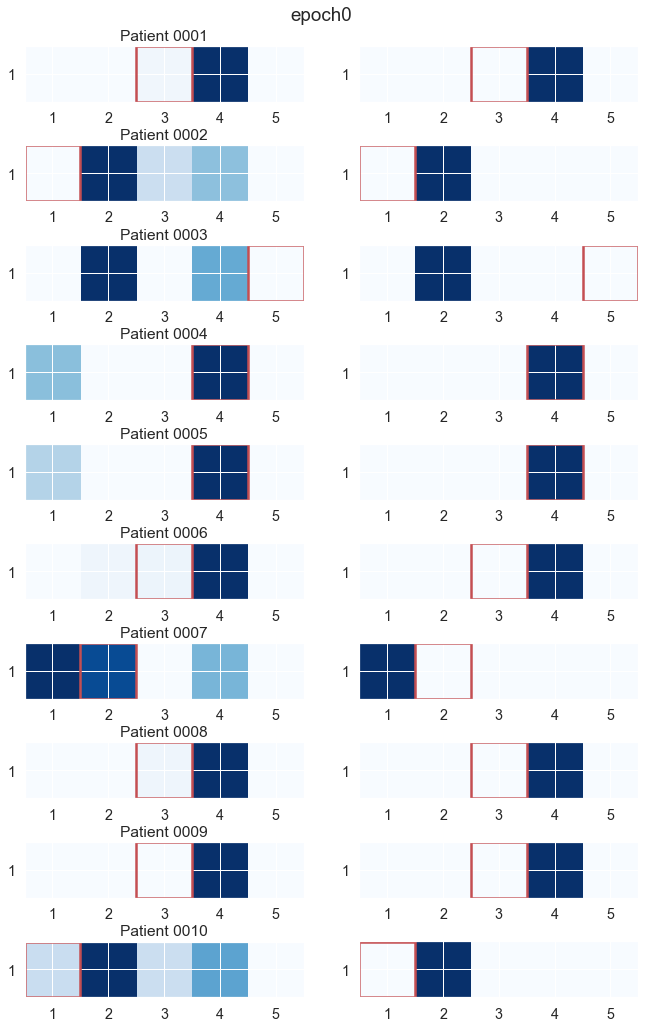

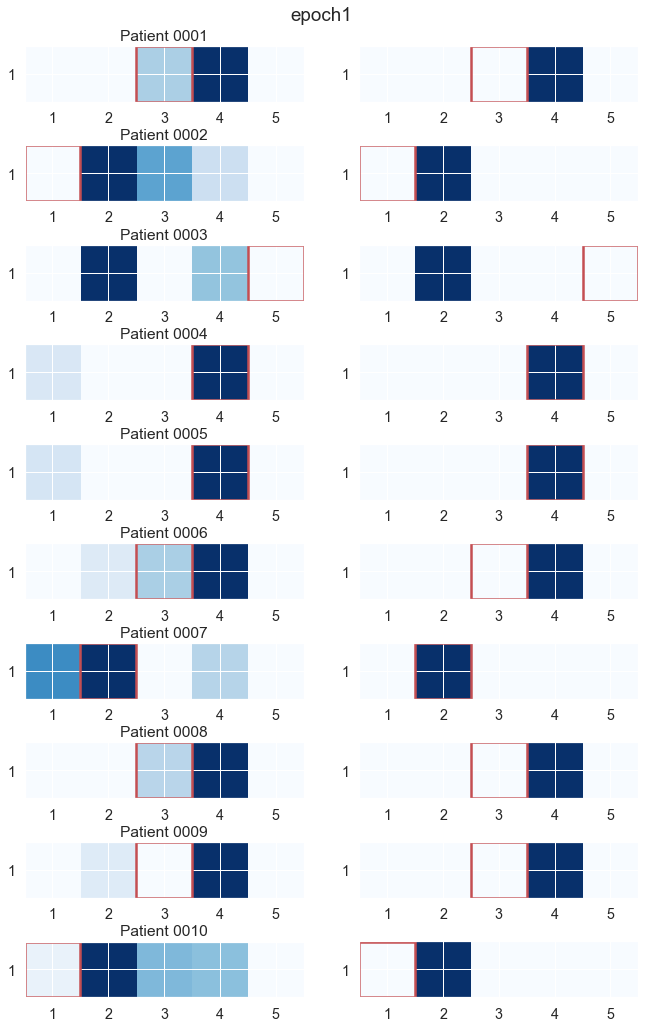

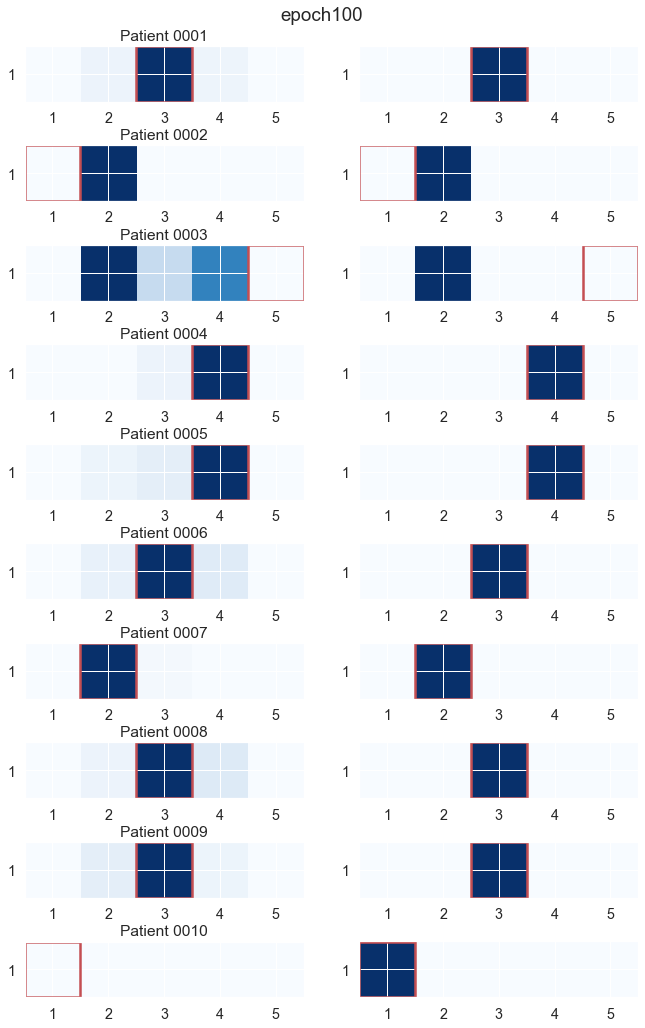

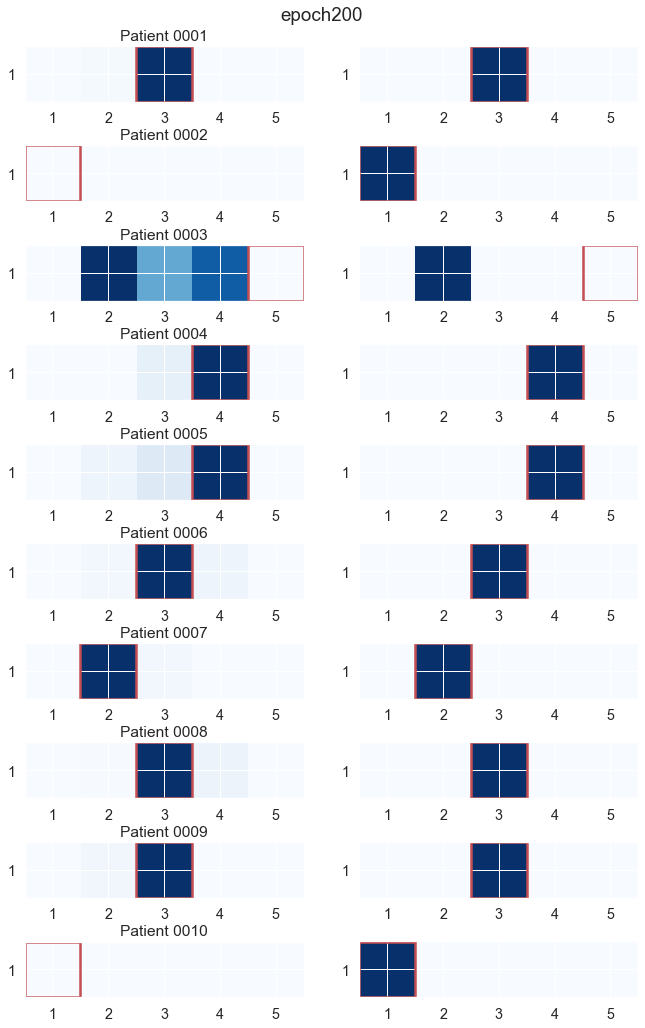

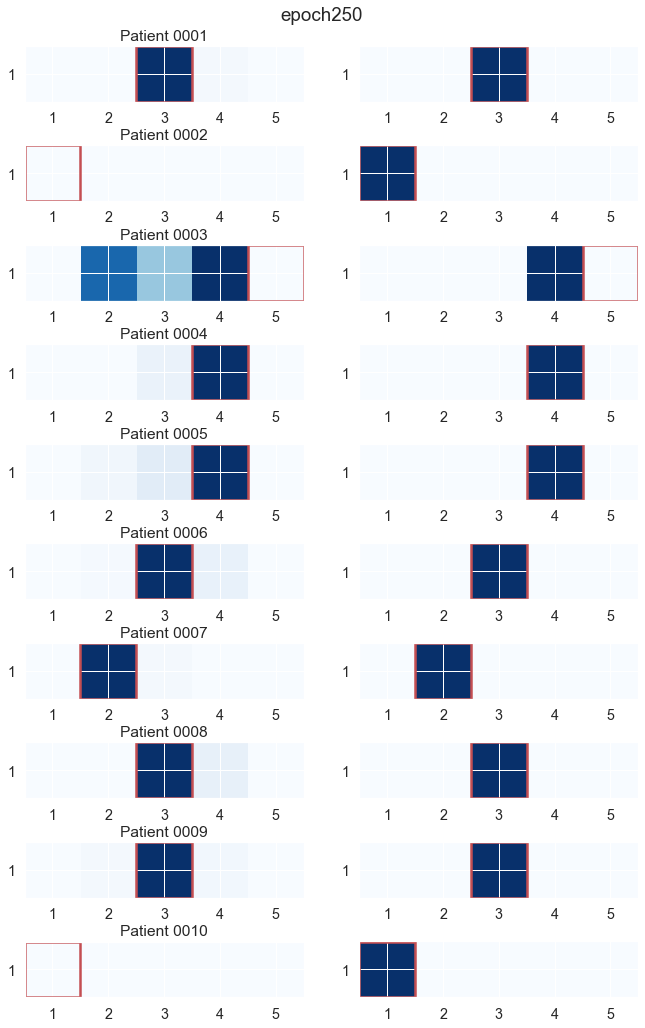

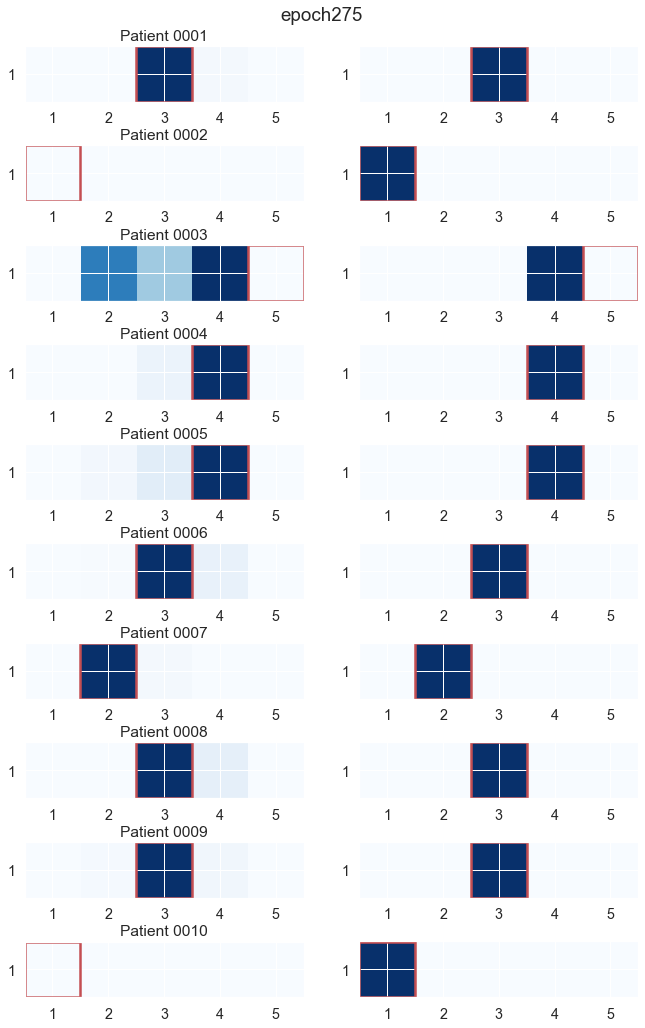

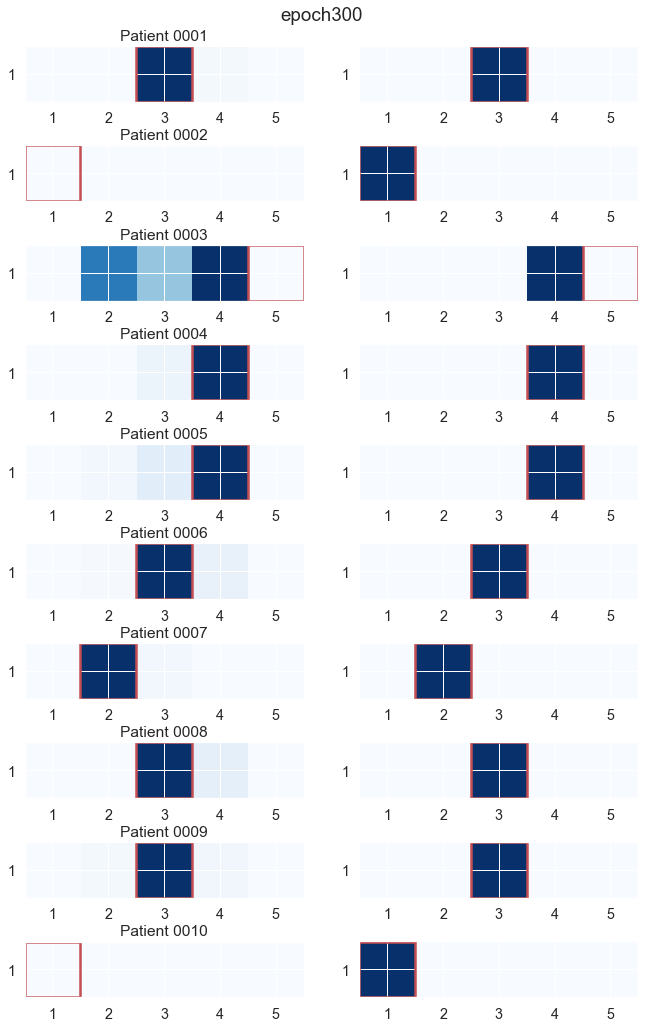

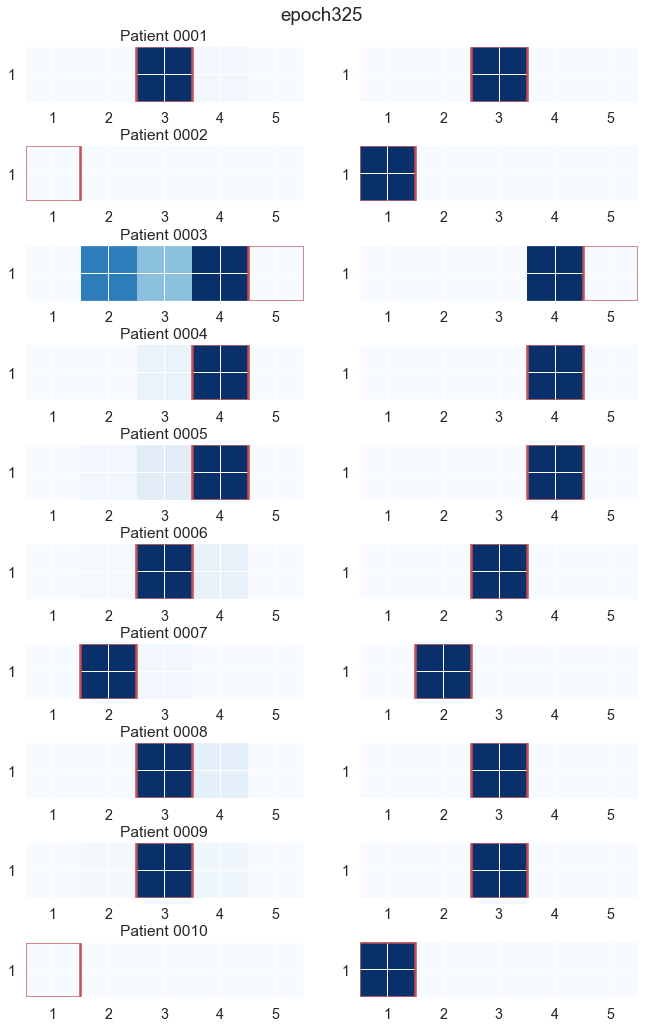

In [16]:
# plot logits
plot_Z([0, 1, 100, 200, 250, 275, 300, 325], output2, total)

## Pretrained graph embedding (max), joint learning

### soft version

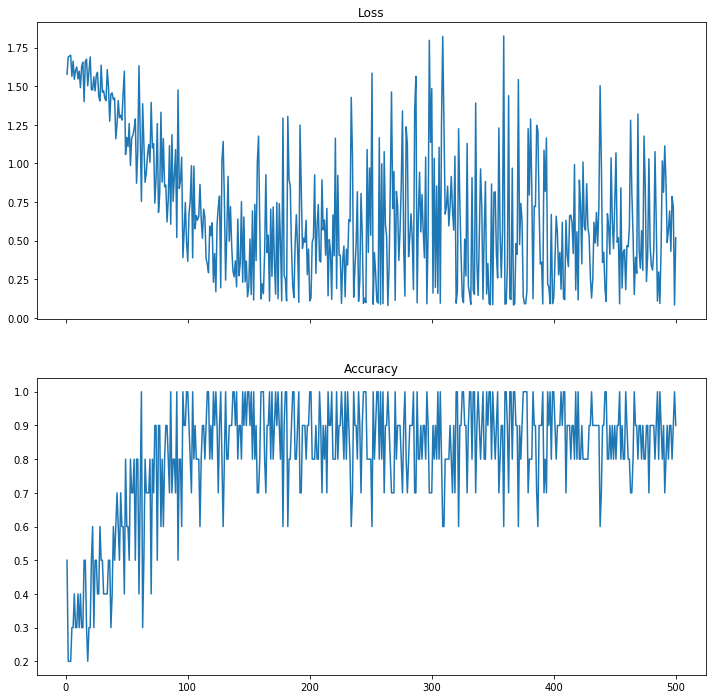

In [18]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-soft/'
plot_loss_acc(dir_path+'log_2020-11-12_13-15.txt')
# plt.savefig('./img/g1551.png', dpi=300)

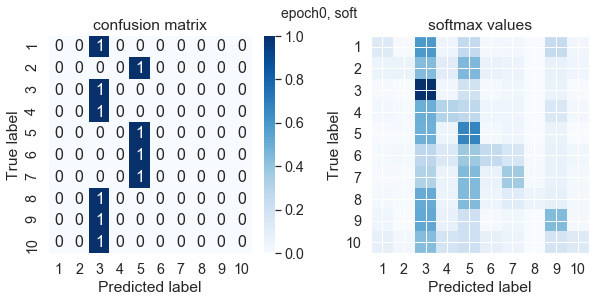

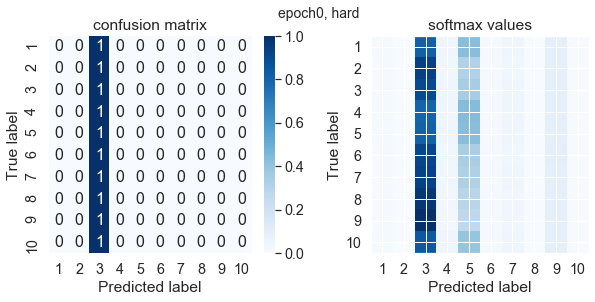

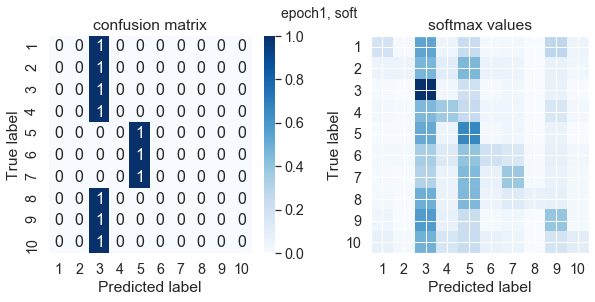

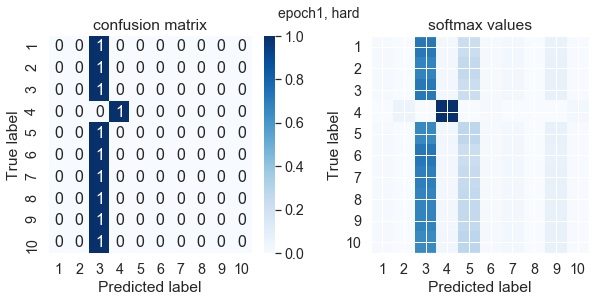

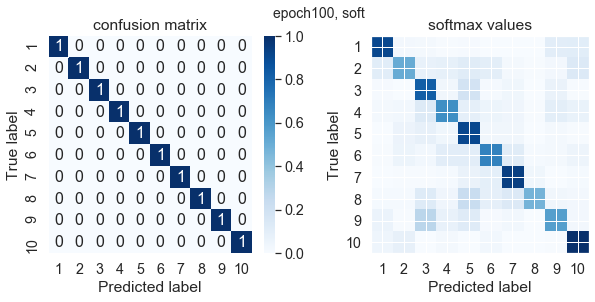

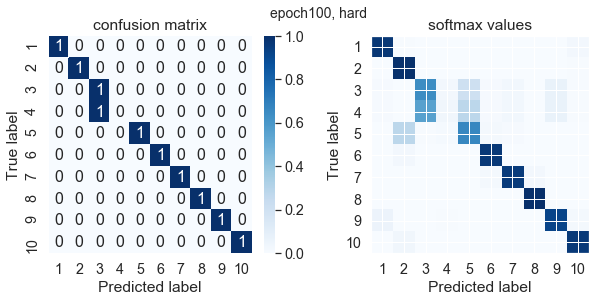

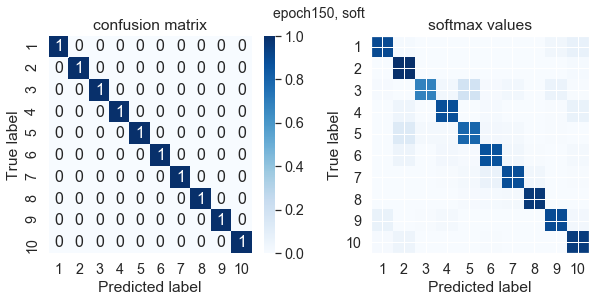

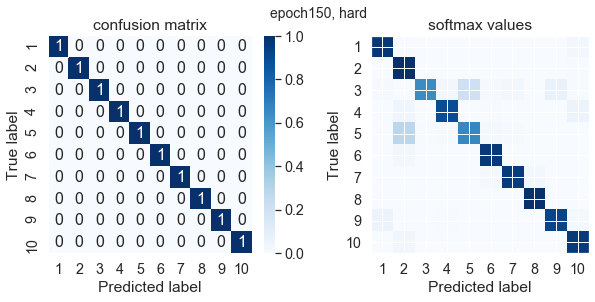

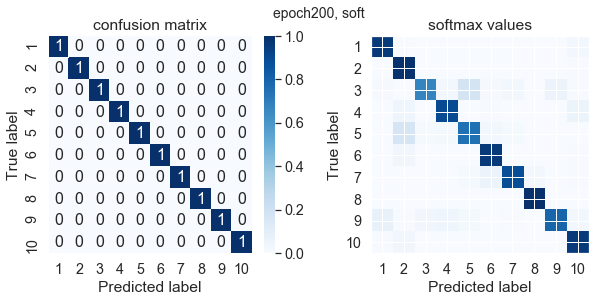

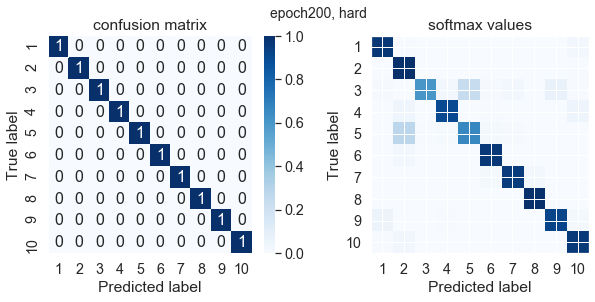

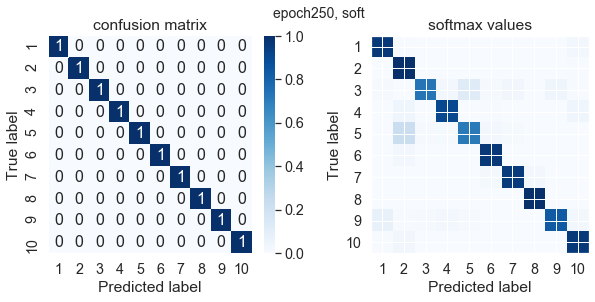

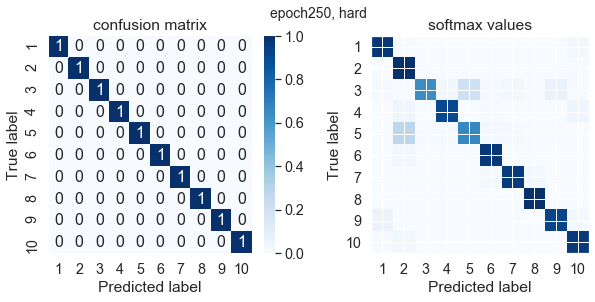

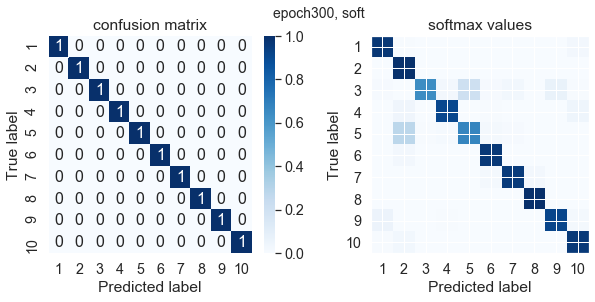

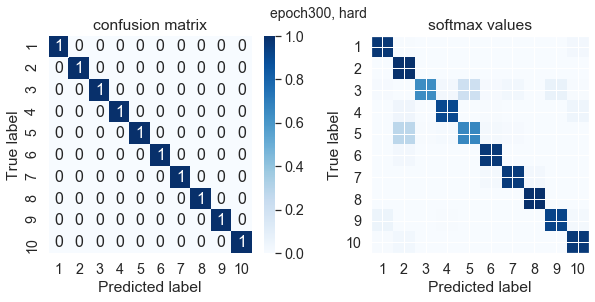

In [51]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-soft/'
output, output2, cfms, cfms_hard, matrices, matrices_hard = \
plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, [0, 1, 100, 150, 200, 250, 300], \
               ratio=0.05, num_patches=1, plot=True, ge=False, total=total, hard=True)

result = [output, output2, cfms, cfms_hard, matrices, matrices_hard]

# with open(dir_path+'result_repro.pickle', 'wb') as handle:
#     pickle.dump((indices, result), handle, protocol=pickle.HIGHEST_PROTOCOL)


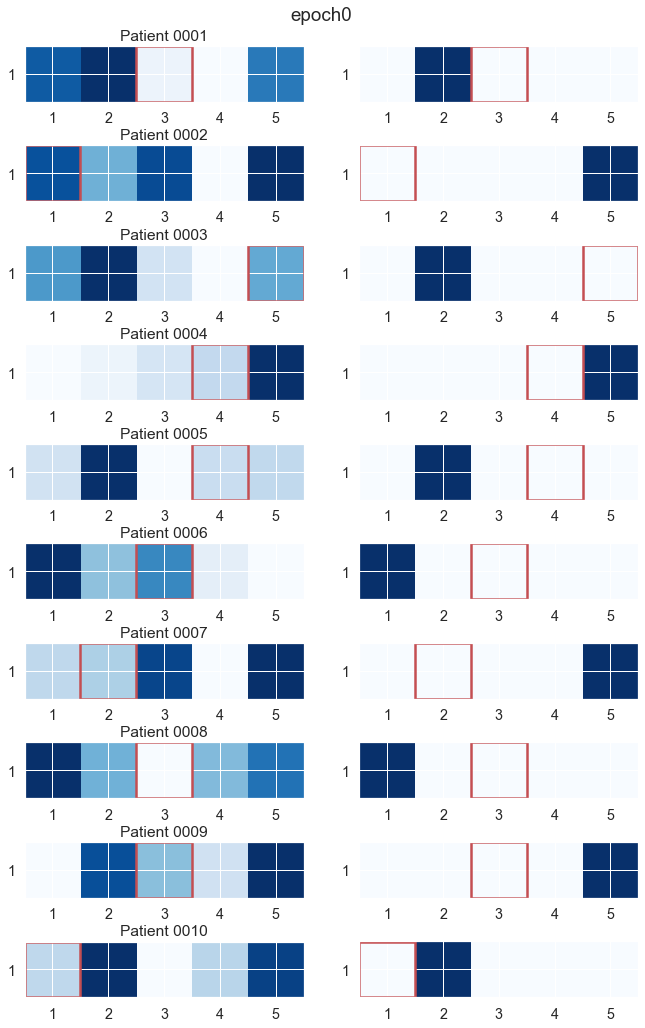

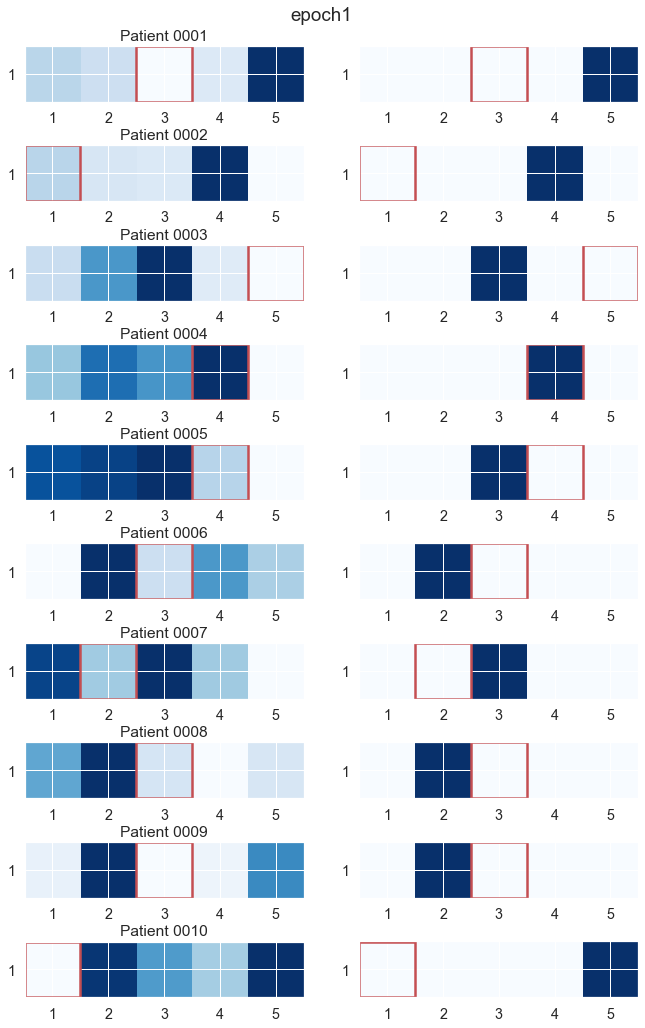

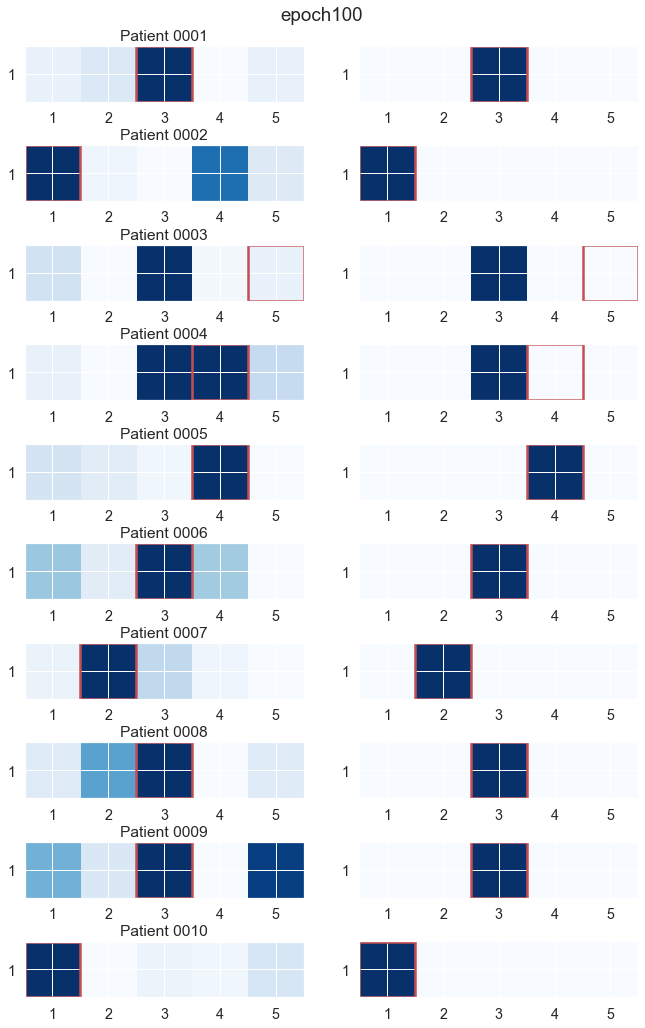

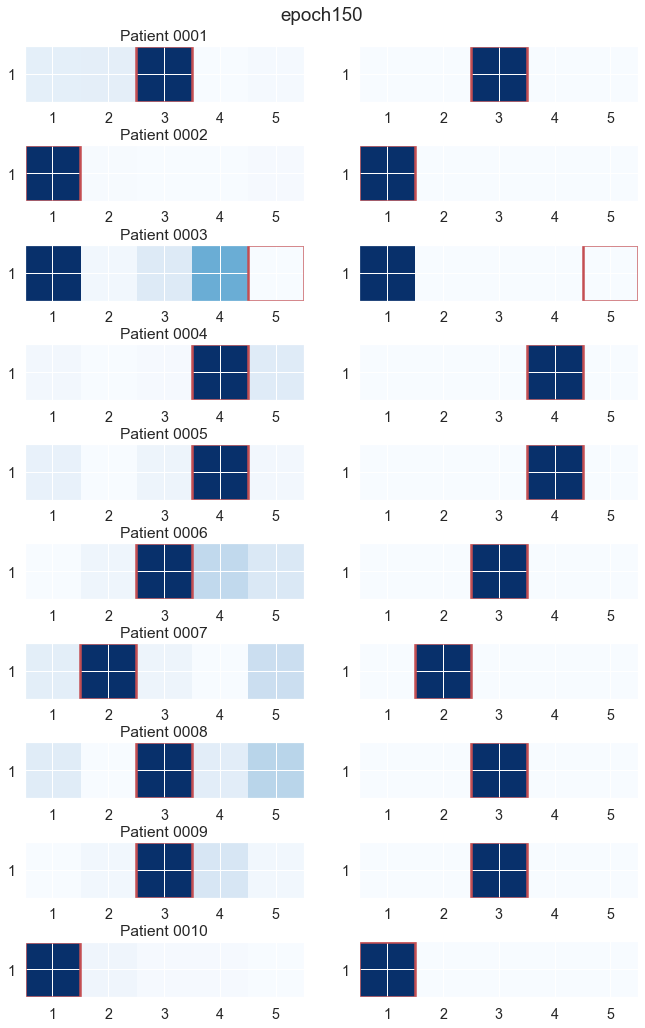

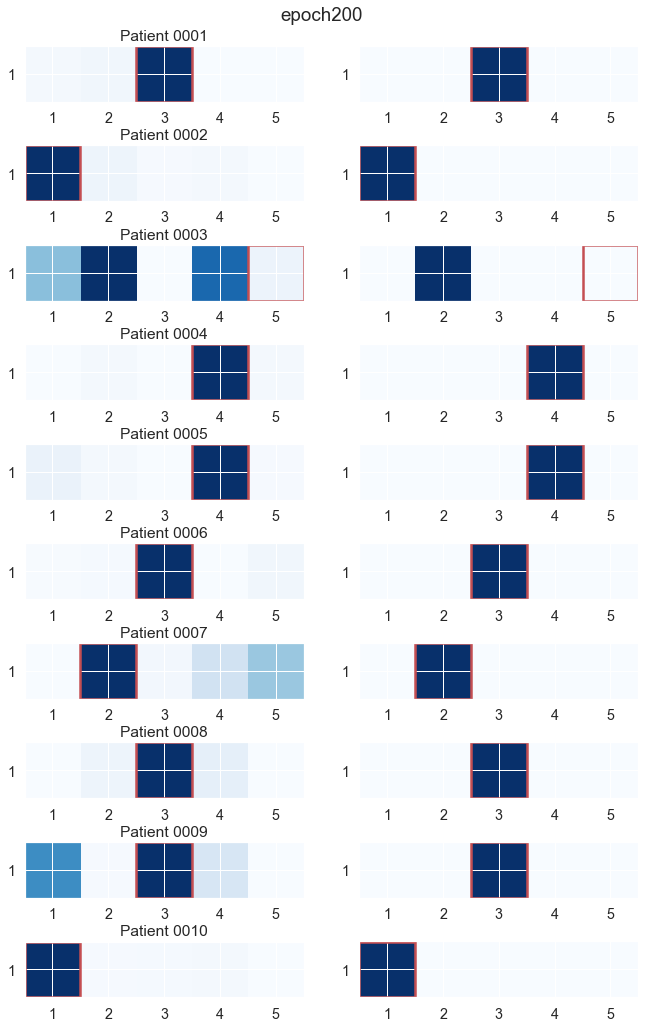

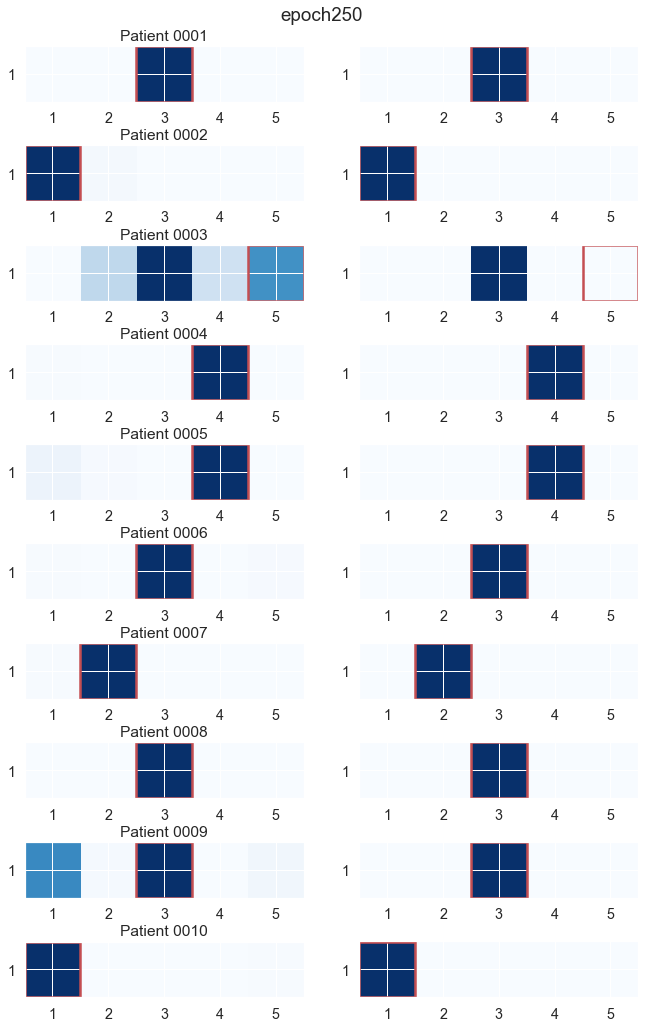

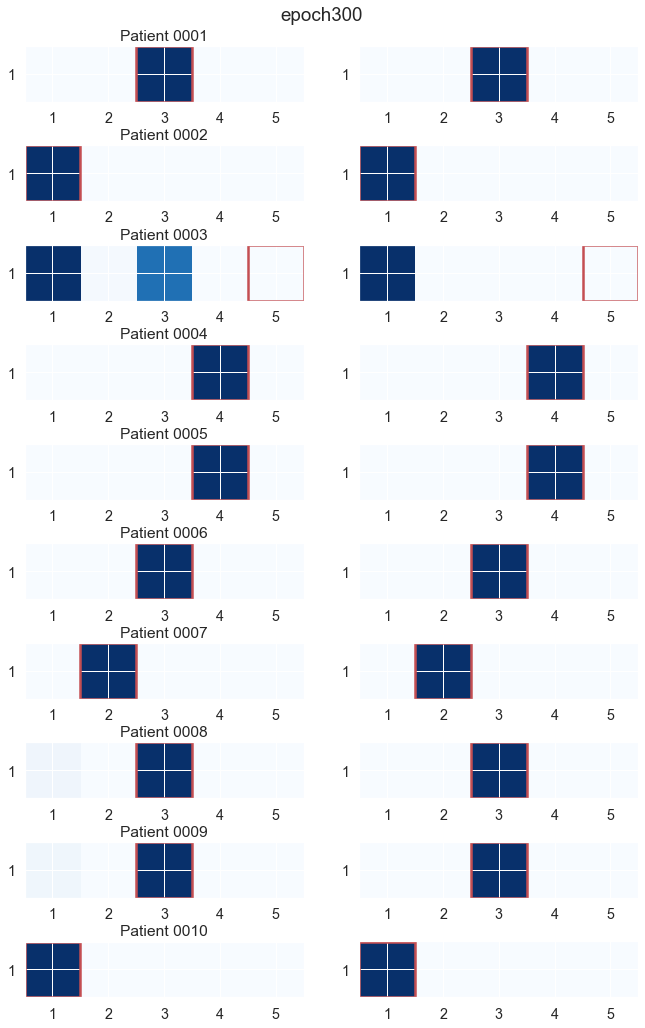

In [28]:
# plot z variable
plot_Z([0, 1, 100, 150, 200, 250, 300], output, total)

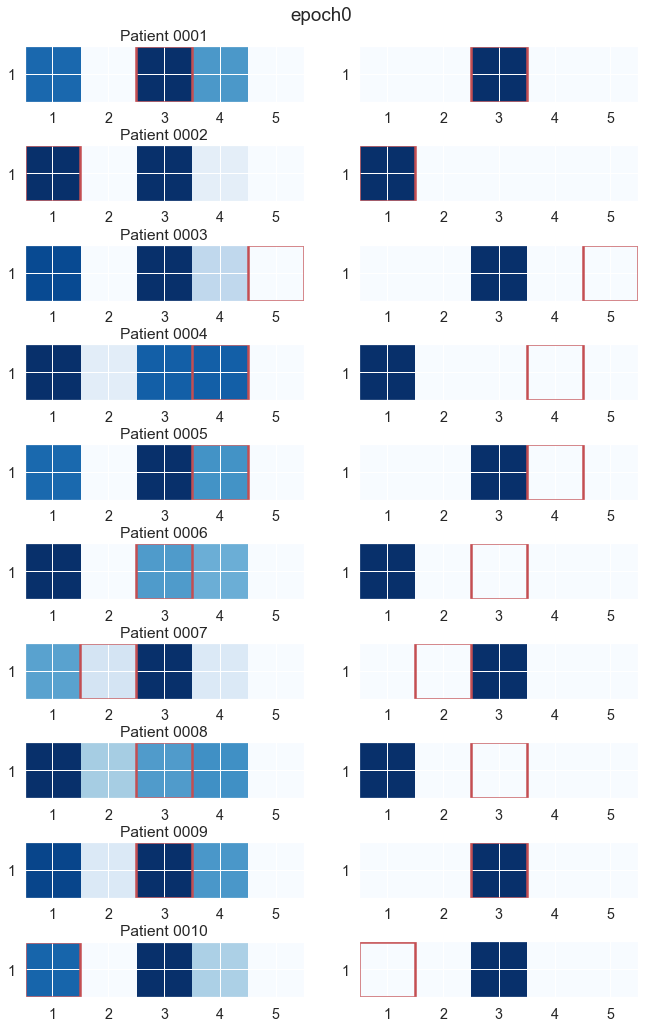

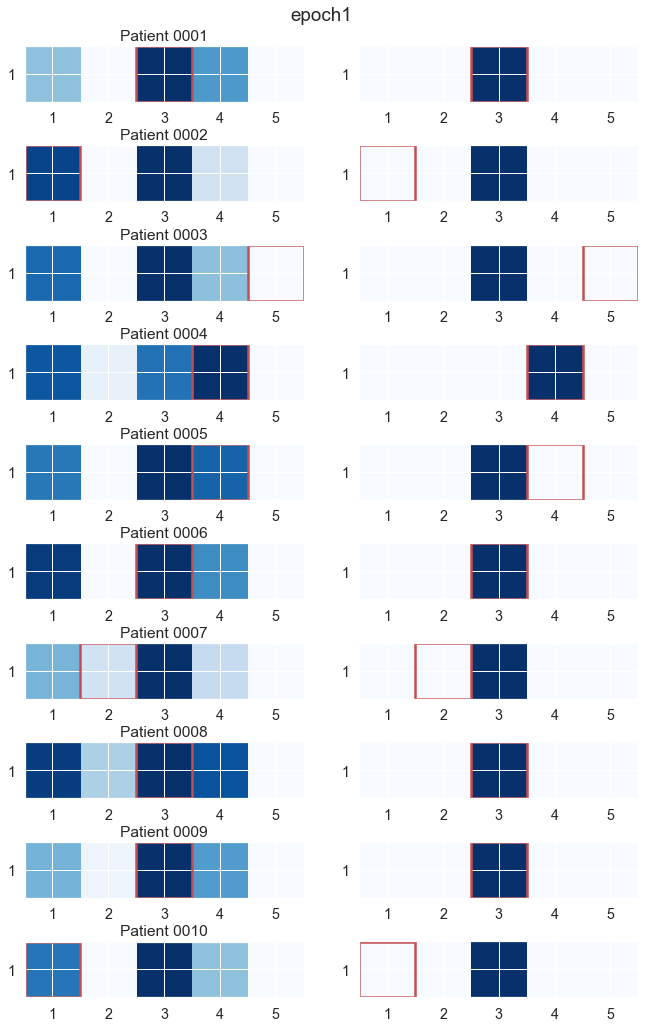

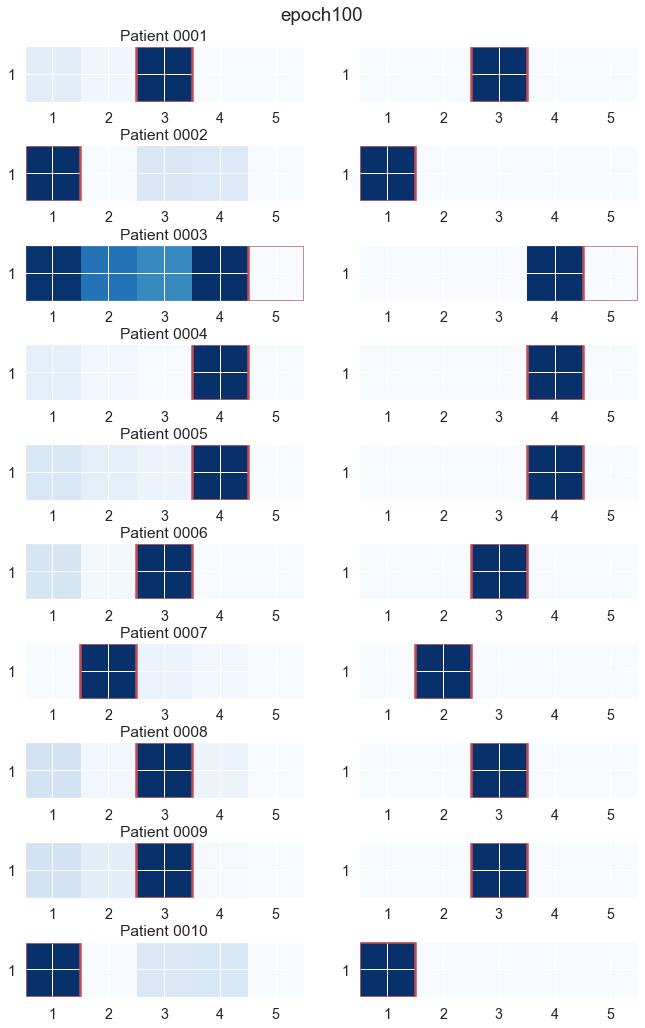

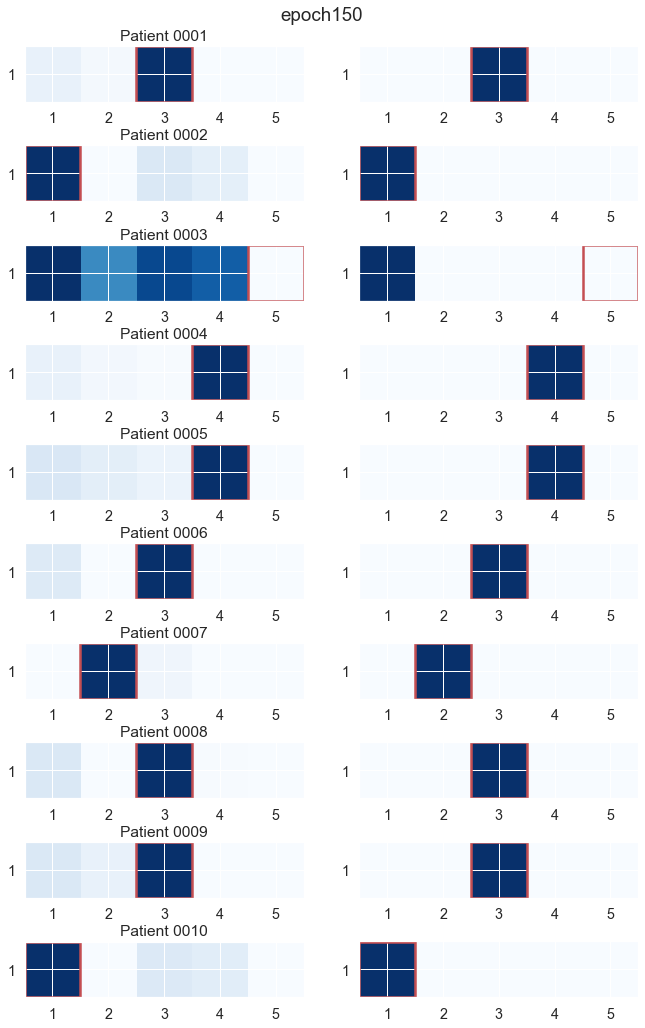

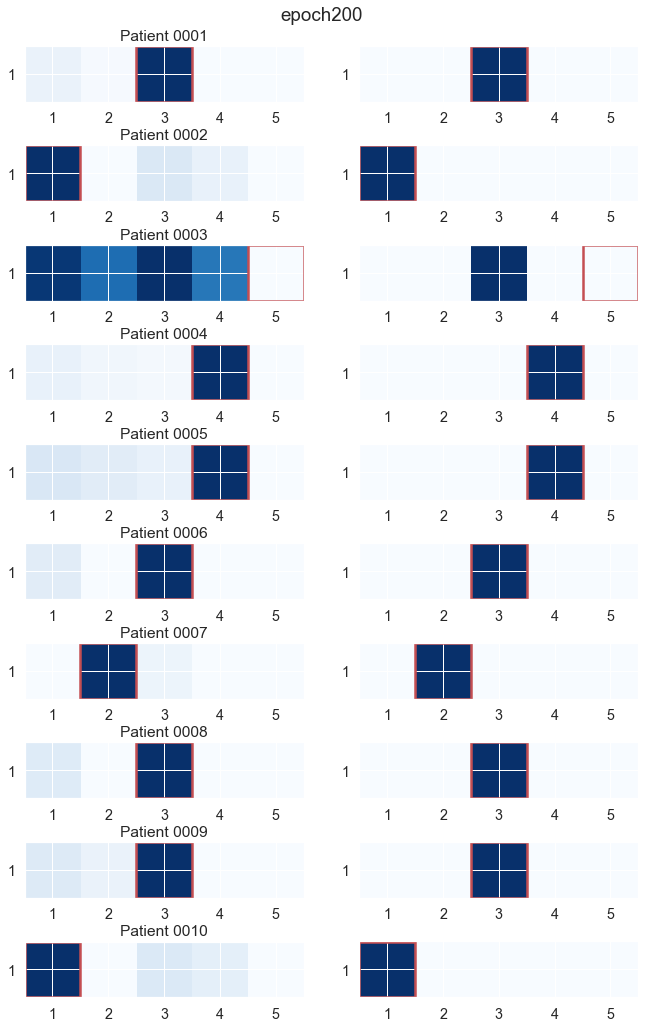

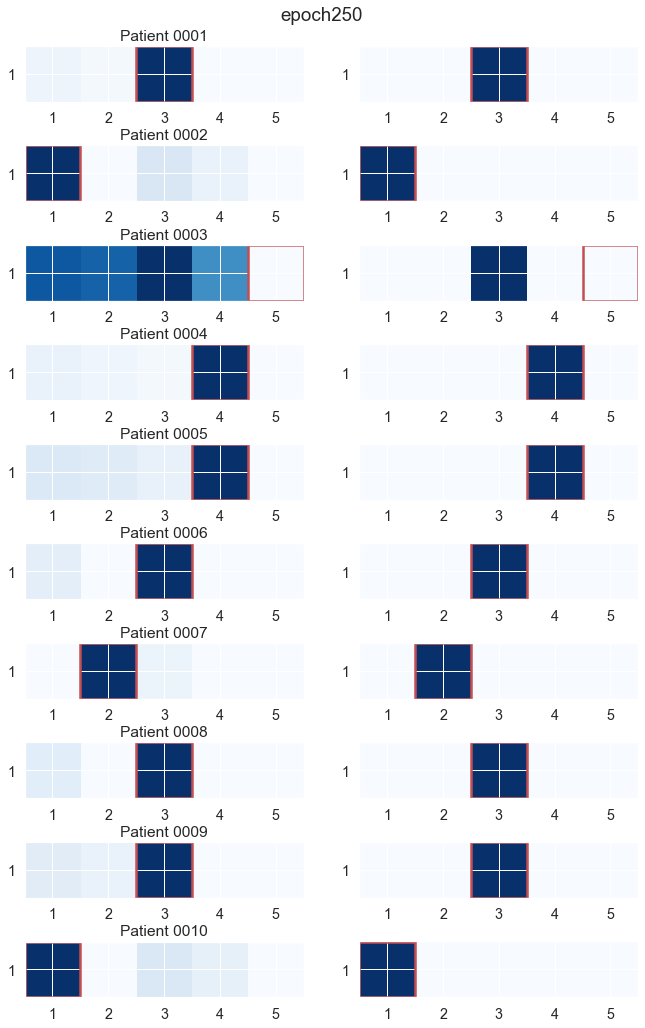

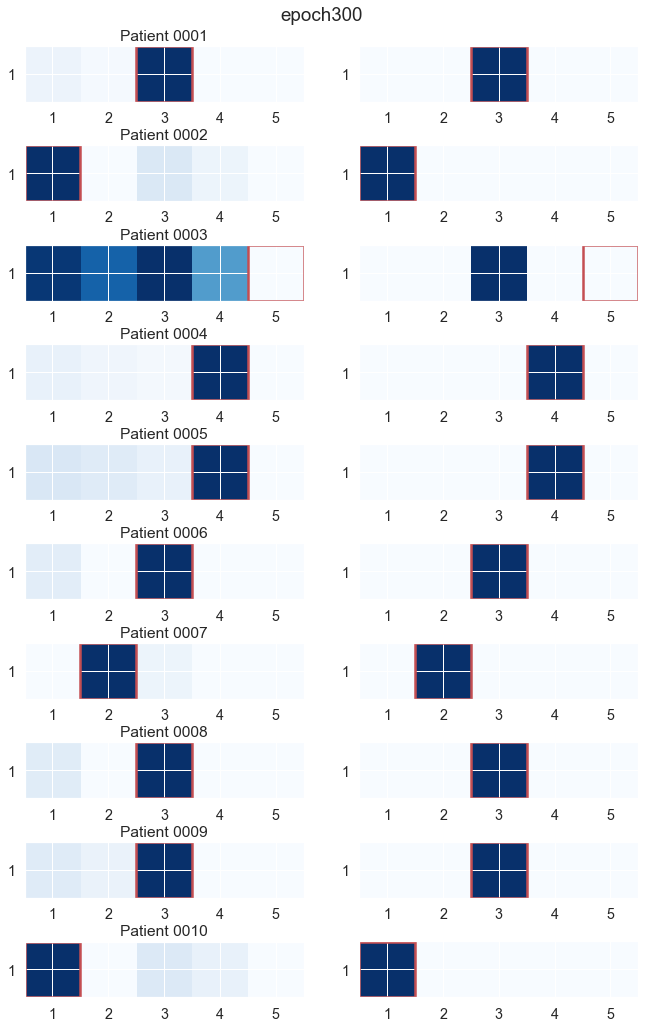

In [29]:
# plot logits variable
plot_Z([0, 1, 100, 150, 200, 250, 300], output2, total)

### hard version

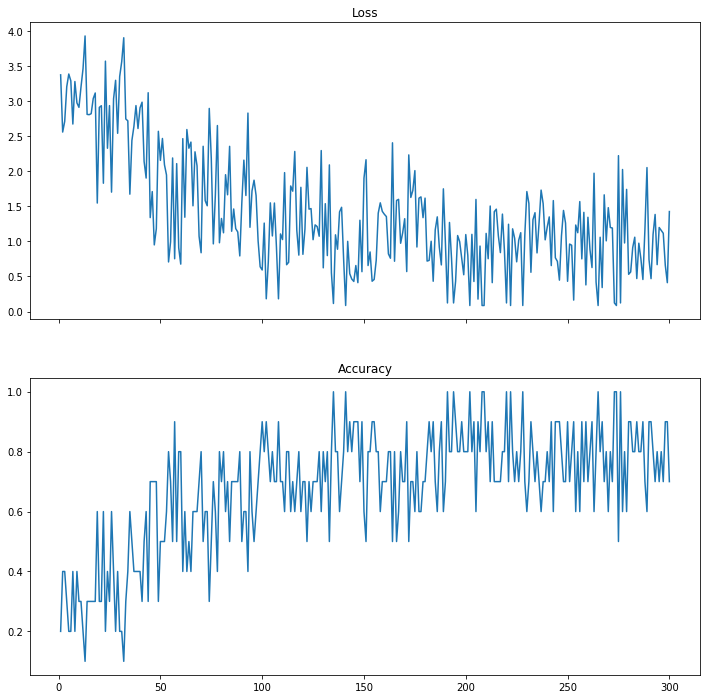

In [19]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-hard/'
plot_loss_acc(dir_path+'log_2020-11-05_17-06.txt')
# plt.savefig('./img/g1561.png', dpi=300)

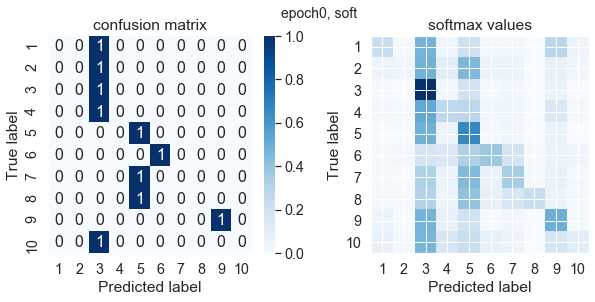

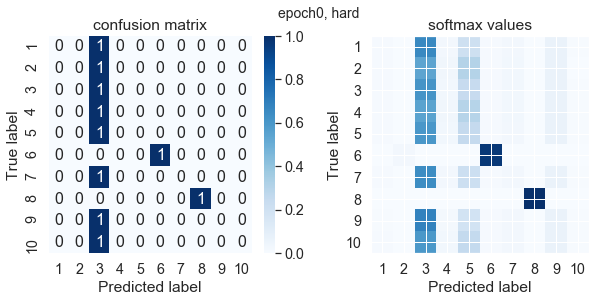

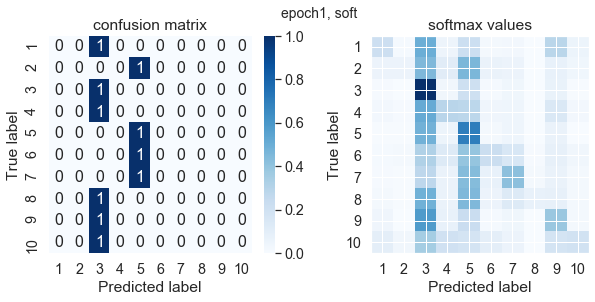

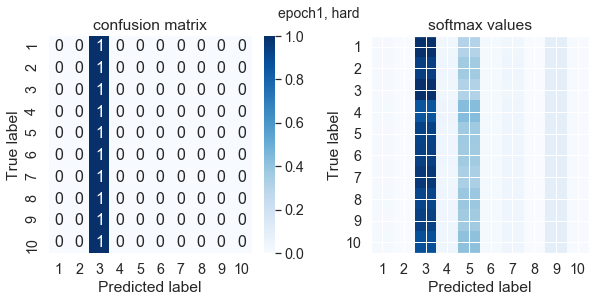

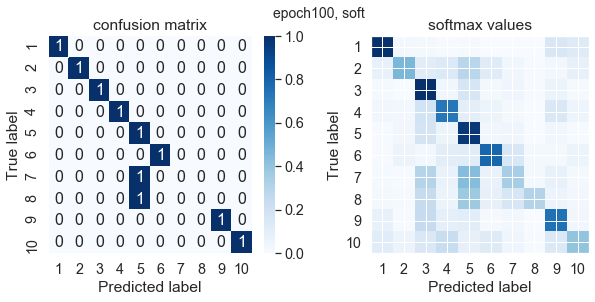

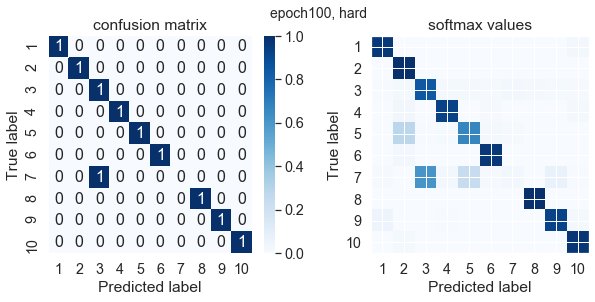

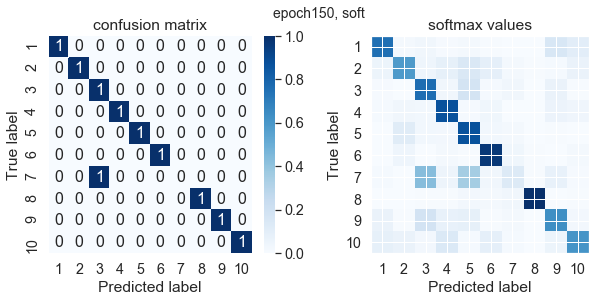

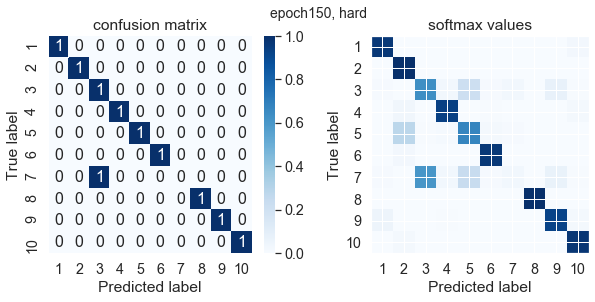

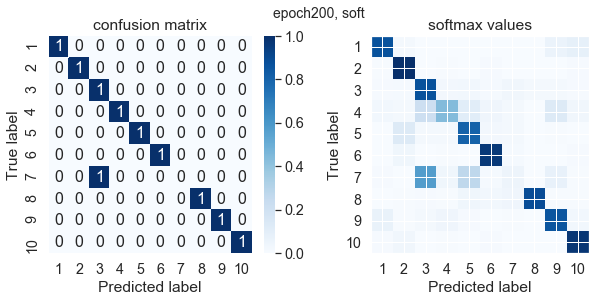

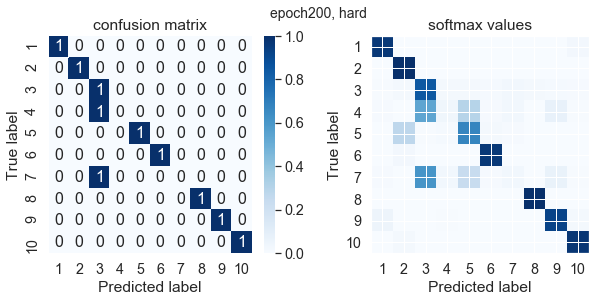

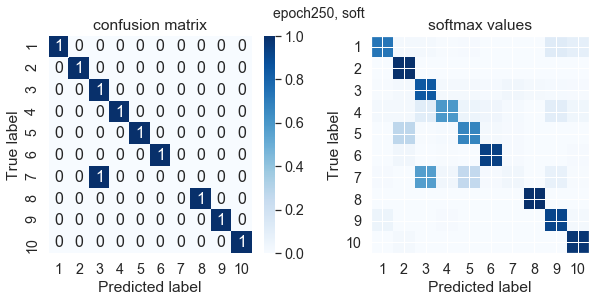

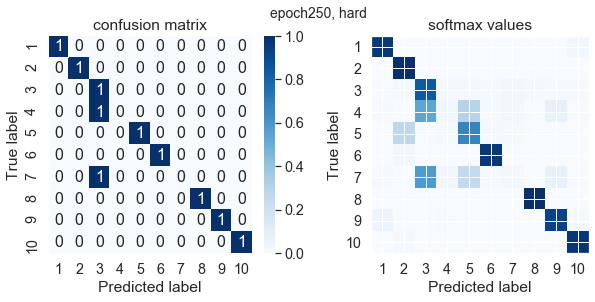

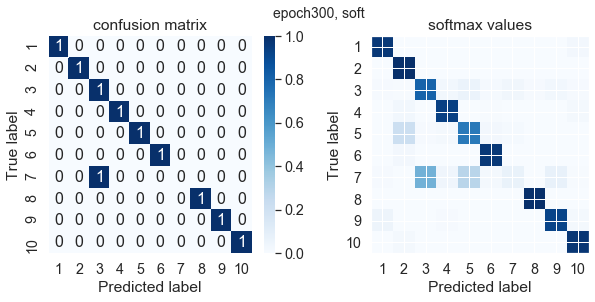

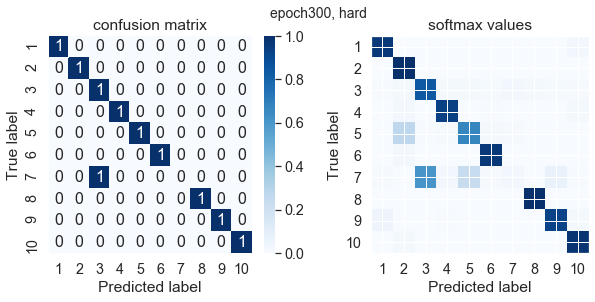

In [41]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-hard/'
output, output2, cfms, cfms_hard, matrices, matrices_hard = \
plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, [0, 1, 100, 150, 200, 250, 300], \
               ratio=0.05, num_patches=1, plot=True, ge=False, total=total, hard=True)

result = [output, output2, cfms, cfms_hard, matrices, matrices_hard]

# with open(dir_path+'result_repro.pickle', 'wb') as handle:
#     pickle.dump((indices, result), handle, protocol=pickle.HIGHEST_PROTOCOL)


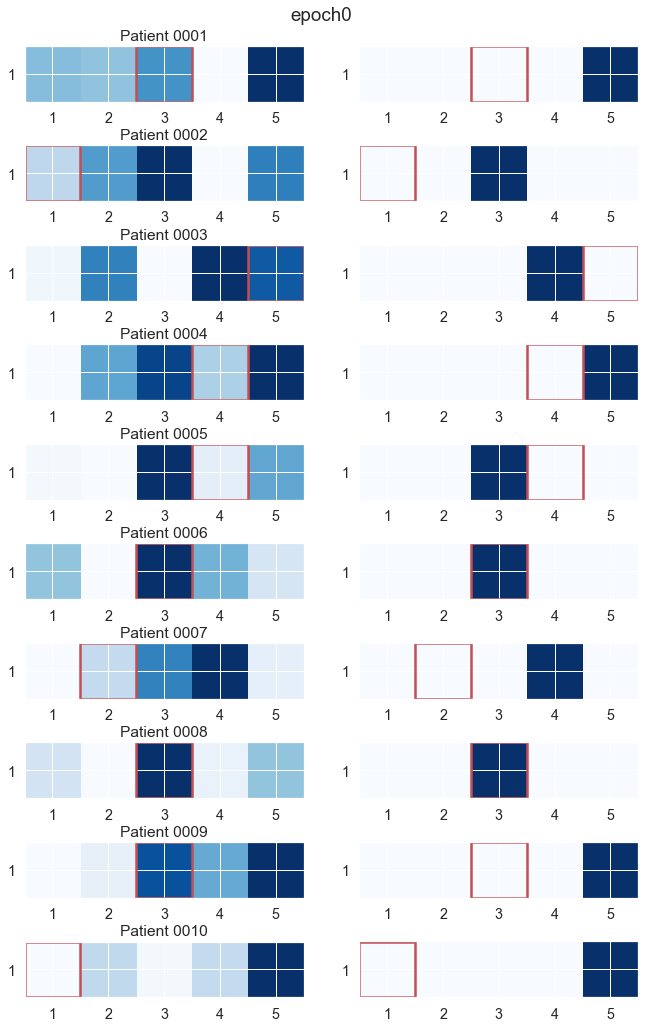

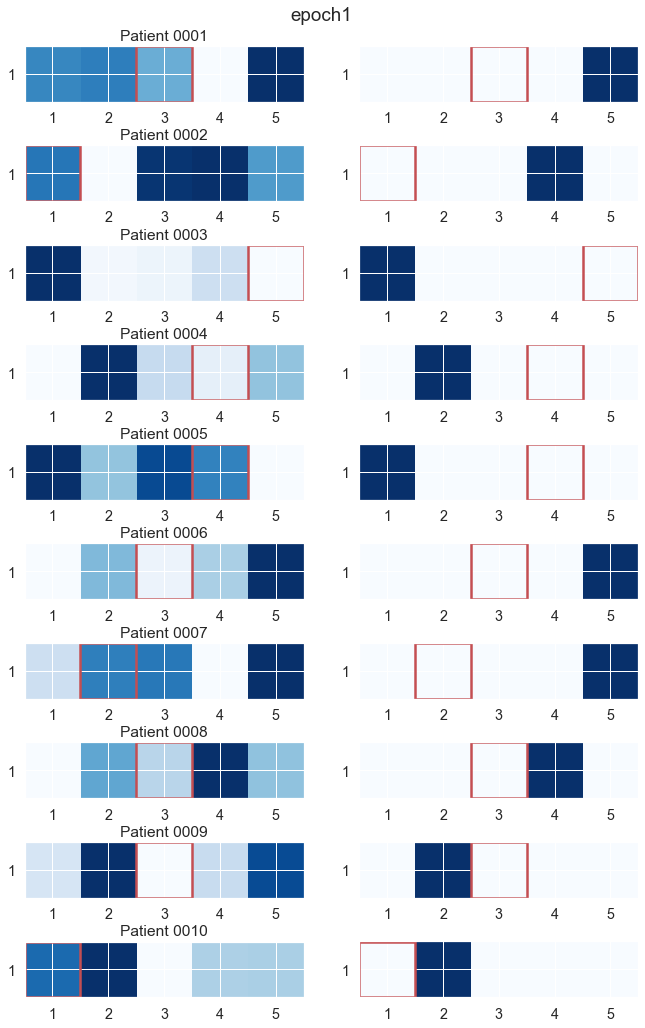

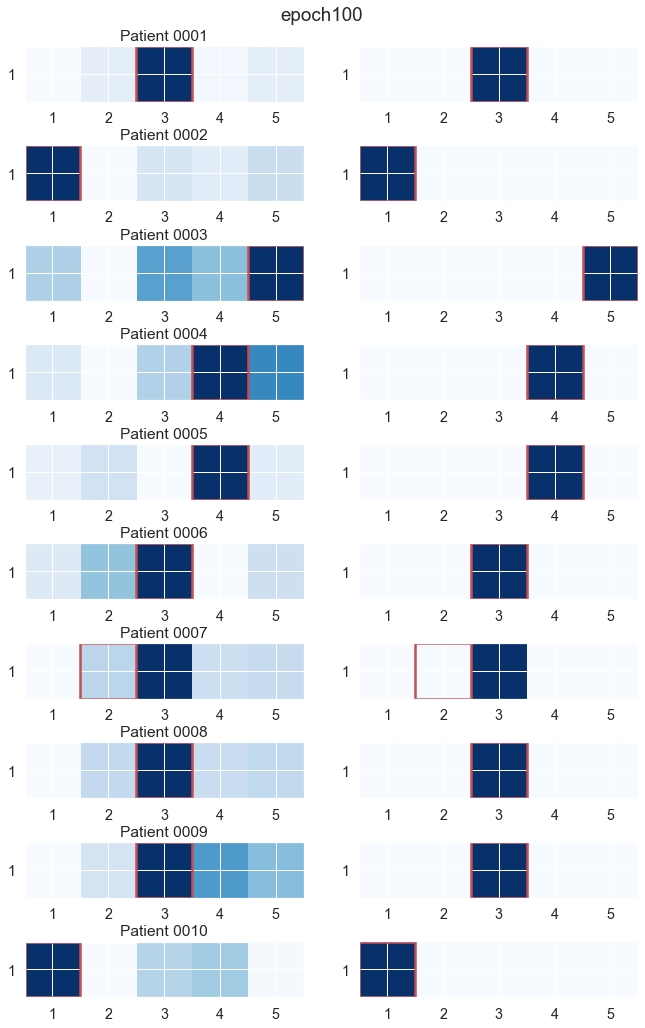

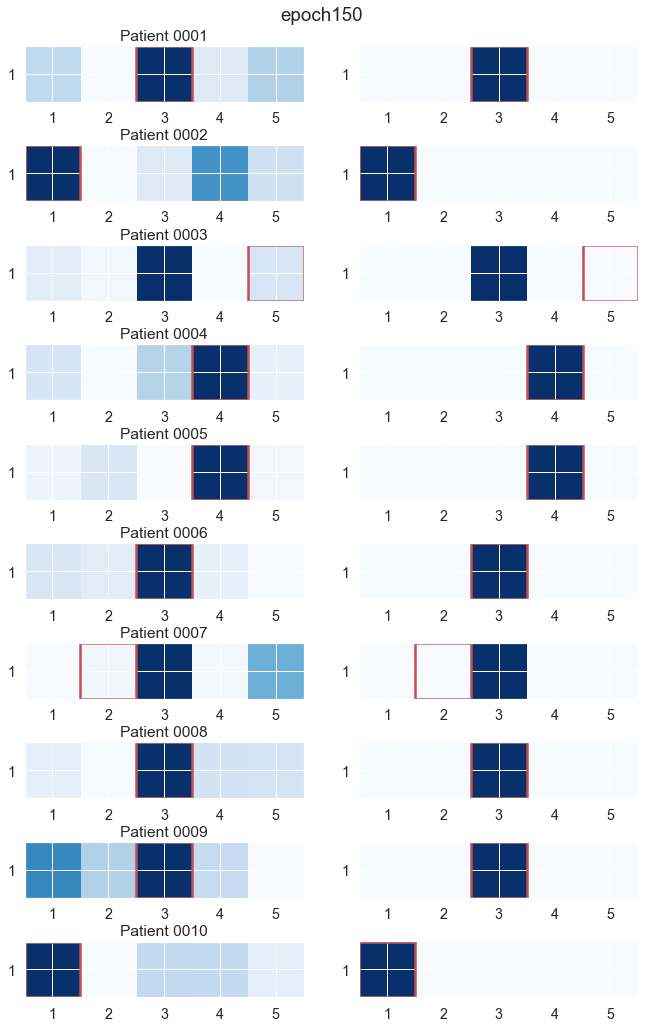

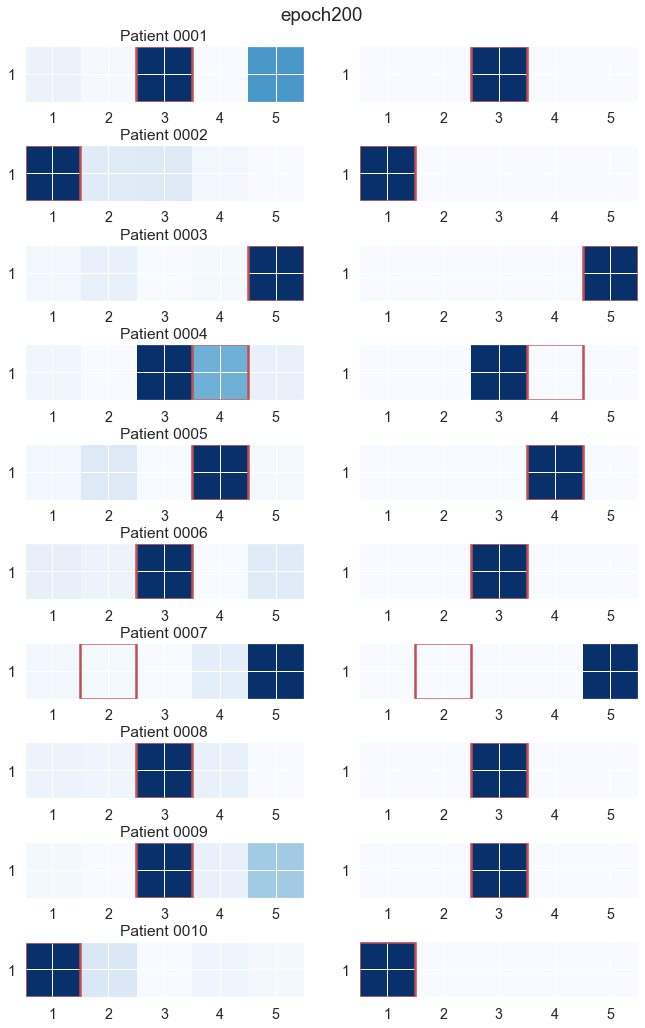

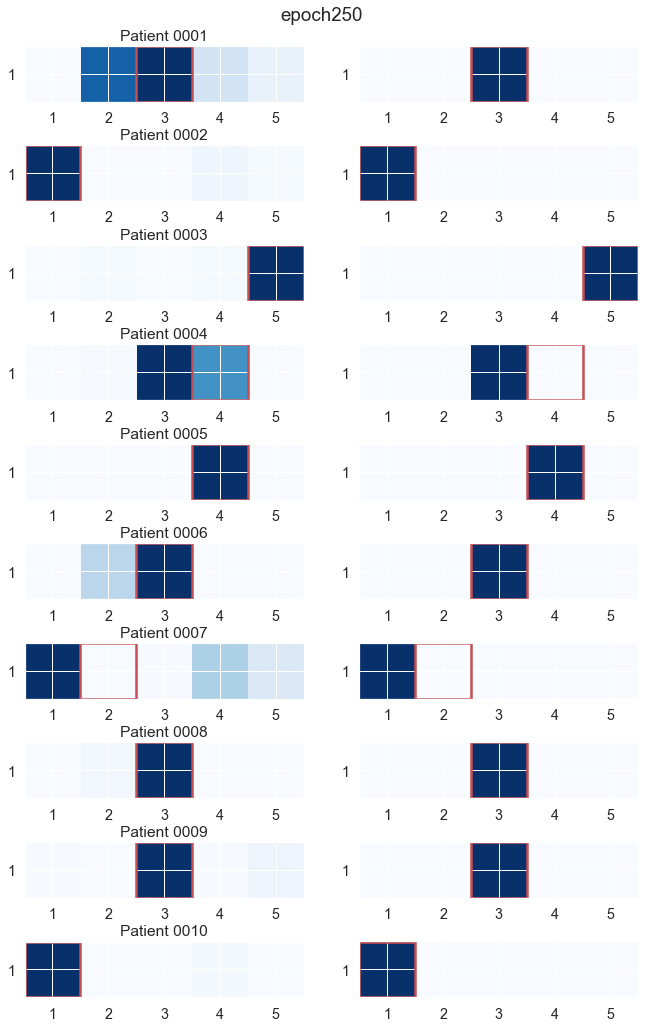

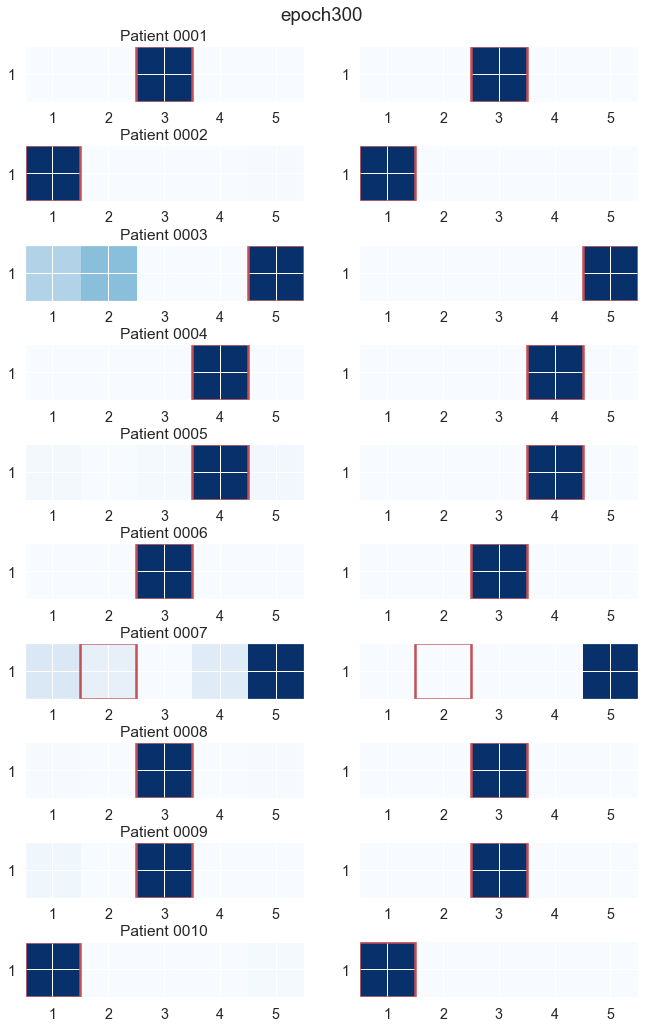

In [42]:
# plot z variable
plot_Z([0, 1, 100, 150, 200, 250, 300], output, total)

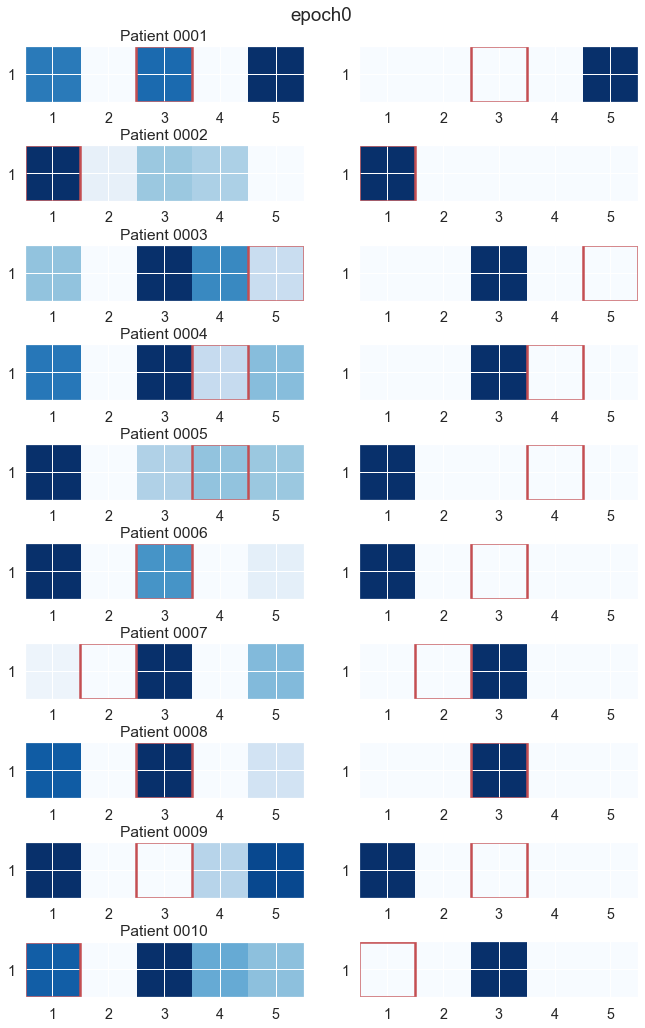

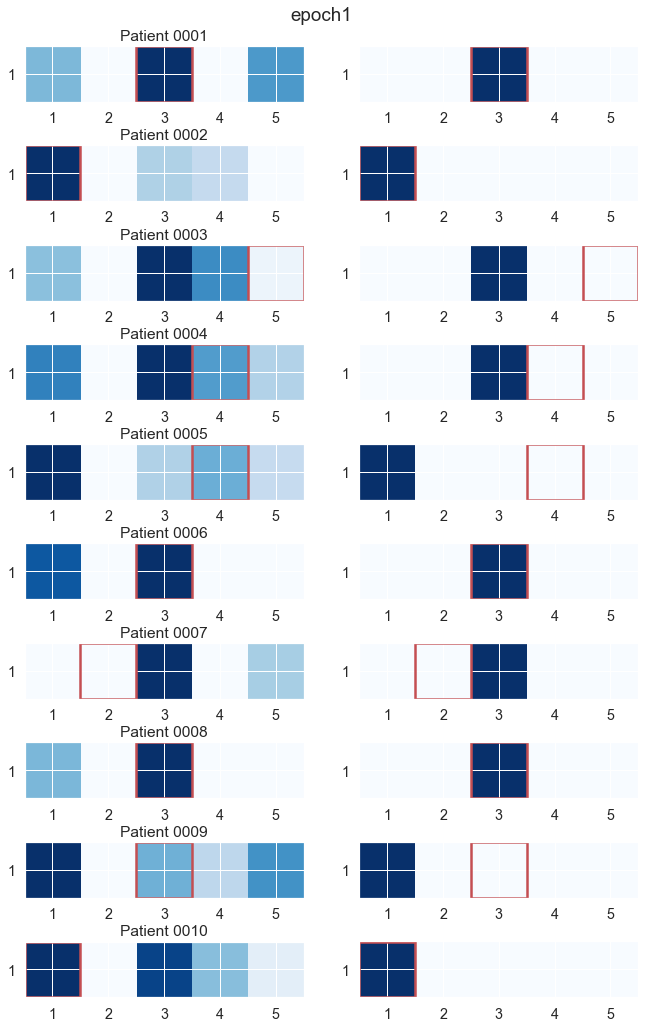

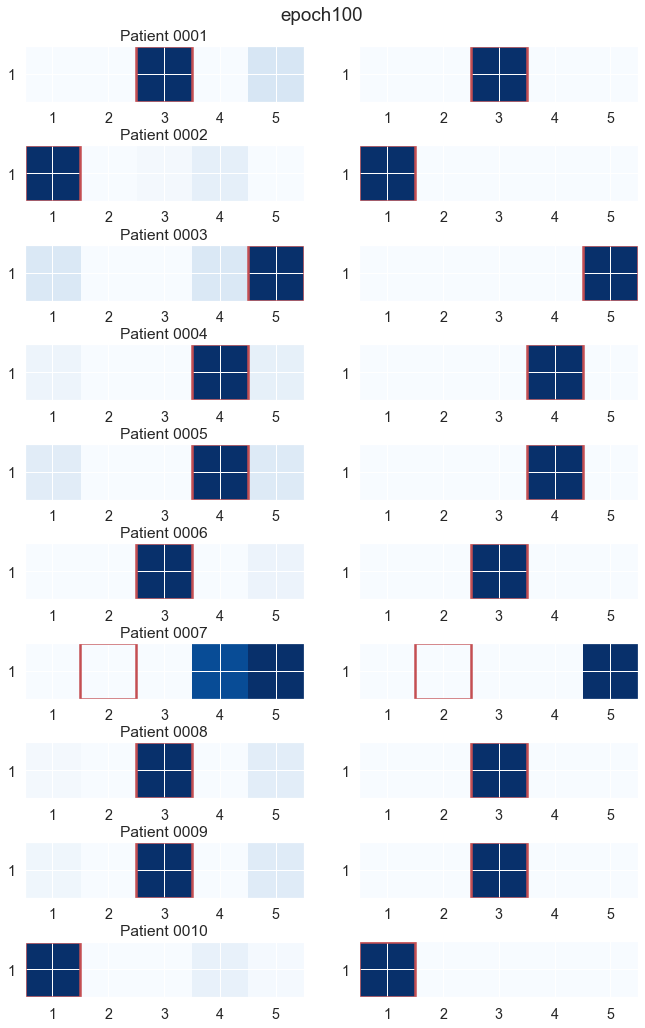

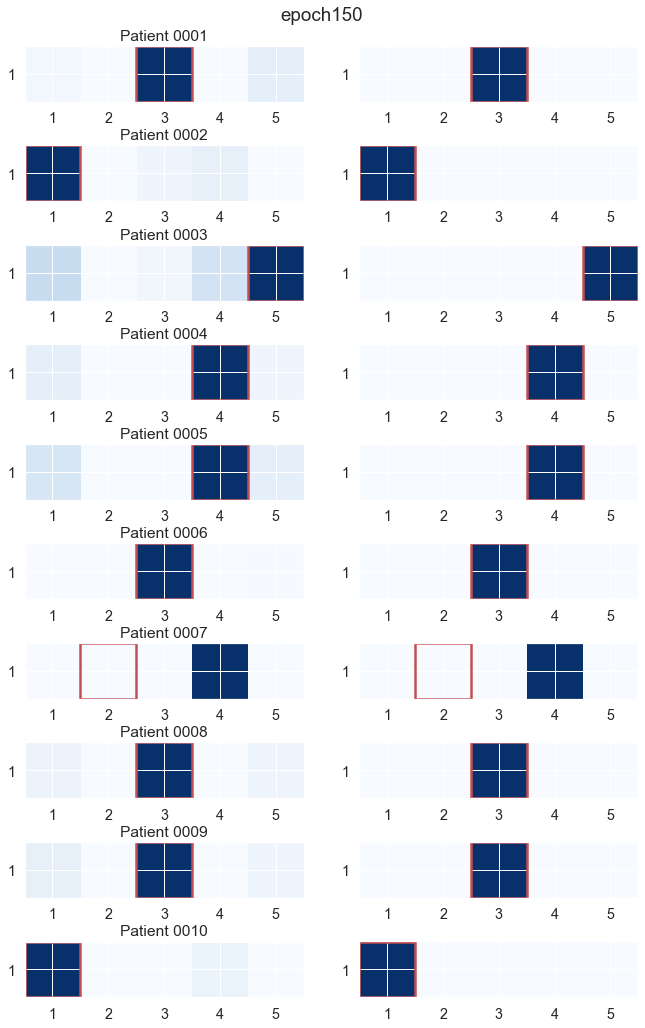

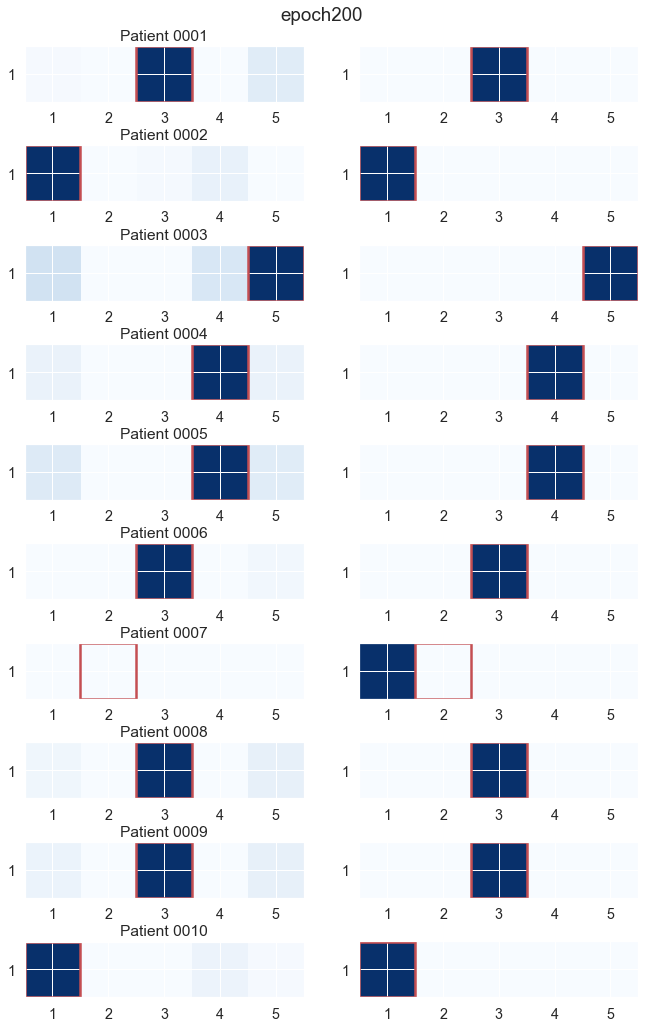

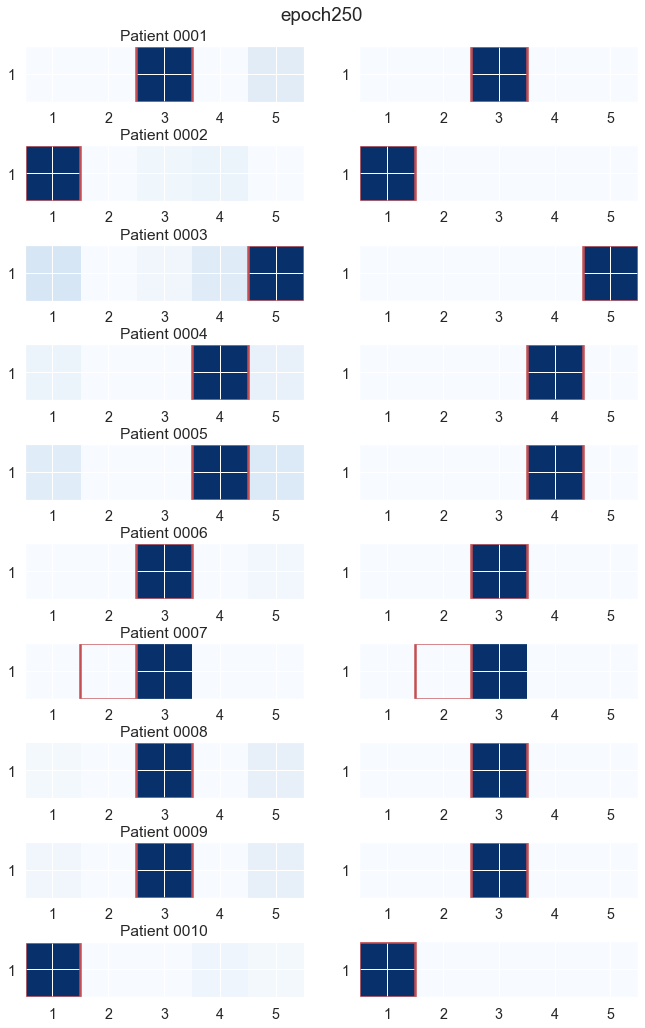

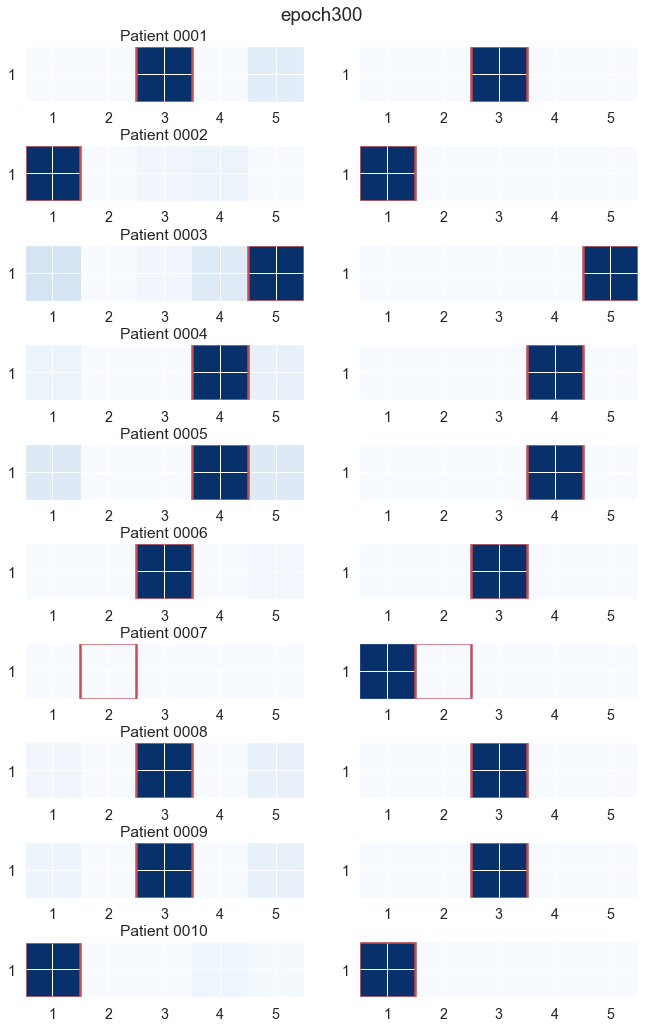

In [45]:
# plot logits
plot_Z([0, 1, 100, 150, 200, 250, 300], output2, total)

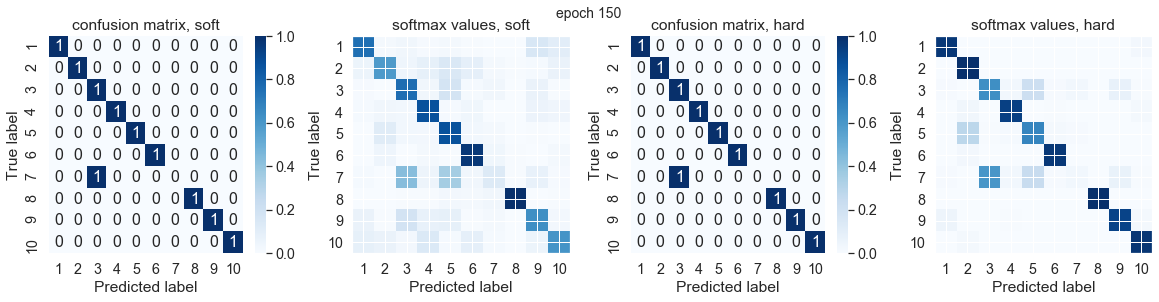

In [47]:
plot_cfm_LogSoftmax2(cfms[3], matrices[3], cfms_hard[3], matrices_hard[3], 'epoch 150')
# plt.savefig('./img/g1562.png', dpi=300)

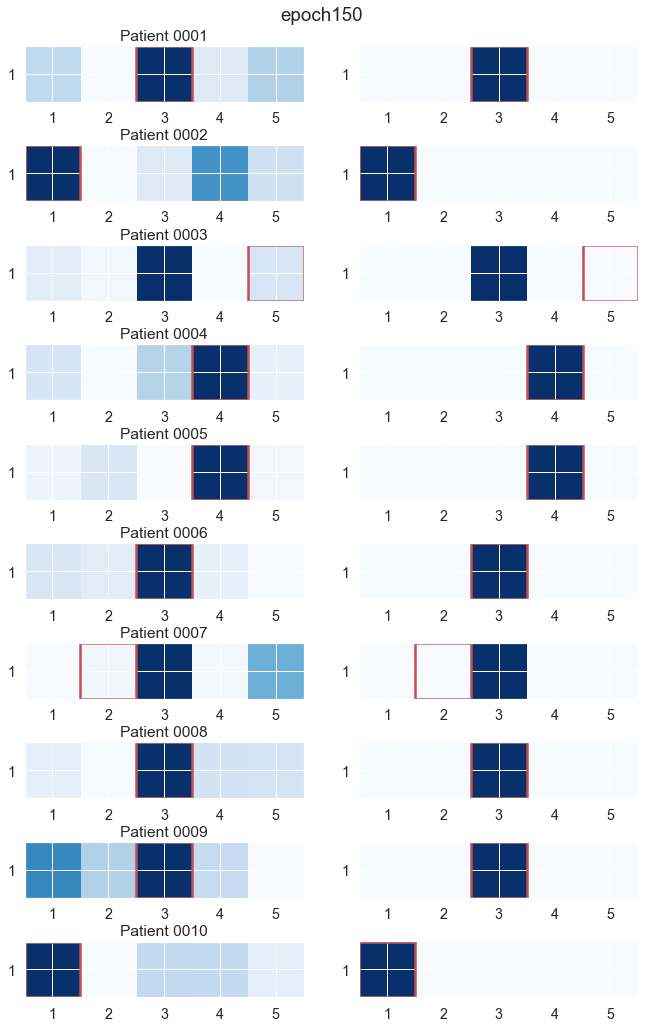

In [48]:
plot_Z([150], output[30:40, :, :], total)
# plt.savefig('./img/g1563.png', dpi=300)

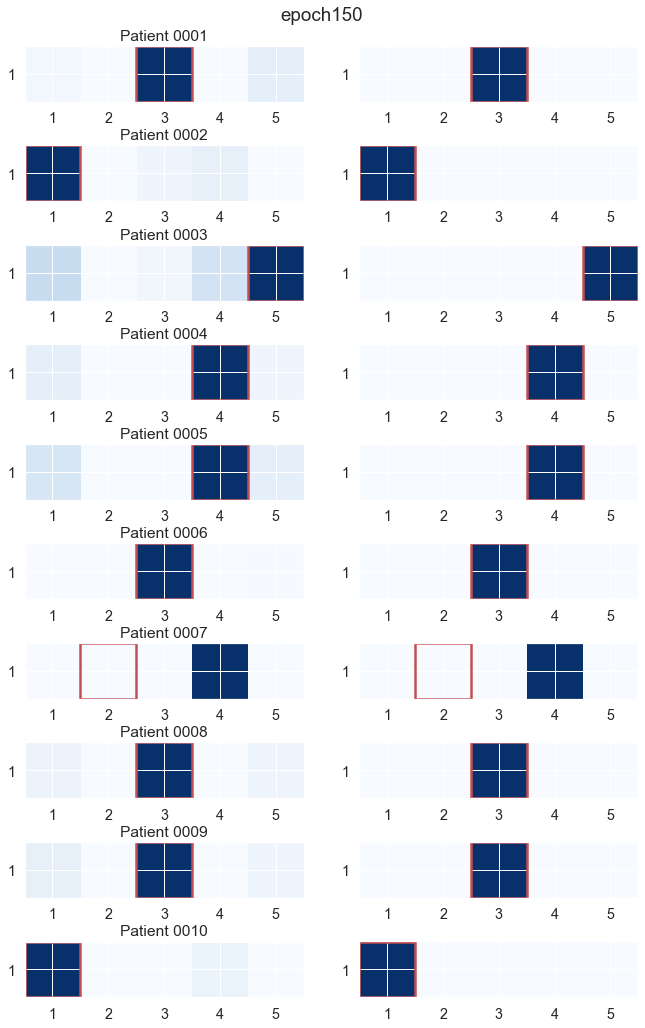

In [50]:
plot_Z([150], output2[30:40, :, :], total)
# plt.savefig('./img/g1564.png', dpi=300)

## Pretrained  graph embedding (max), joint learning, onlyaux loss, hard

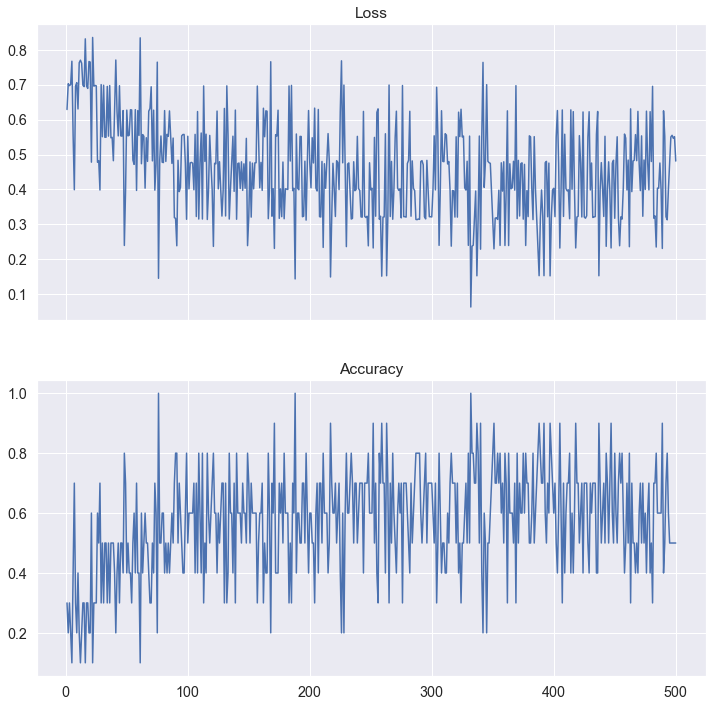

In [71]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-hard-onlyaux/'
plot_loss_acc(dir_path+'log_2021-01-07_23-21.txt')
plt.savefig('./img/g1571.png', dpi=300)

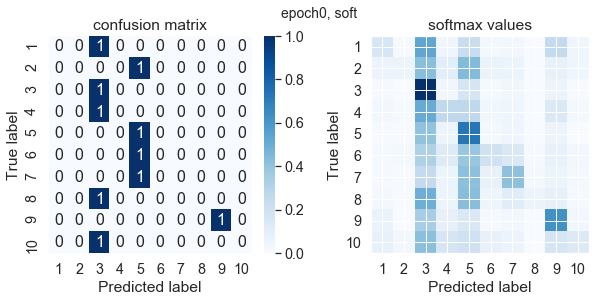

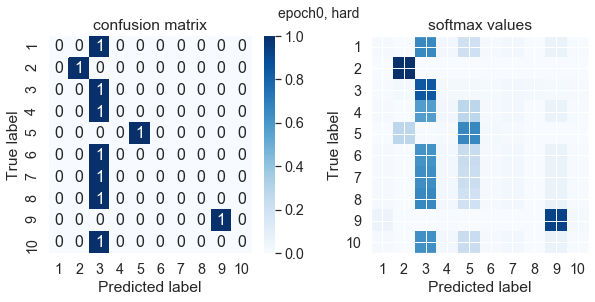

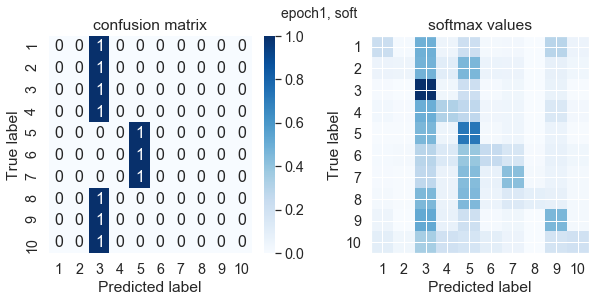

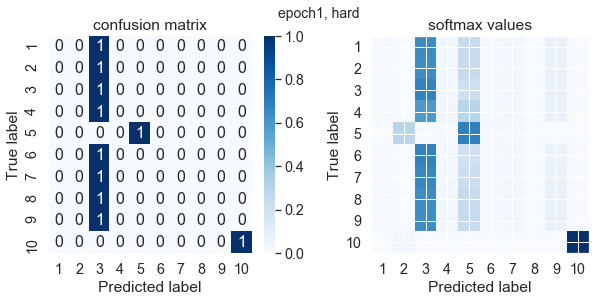

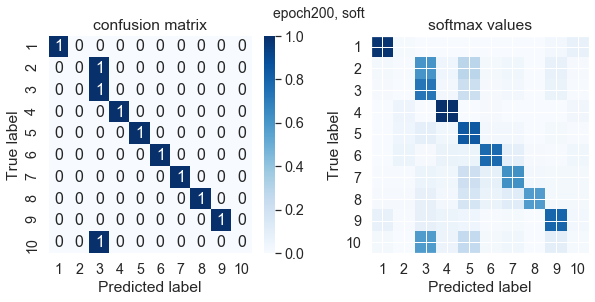

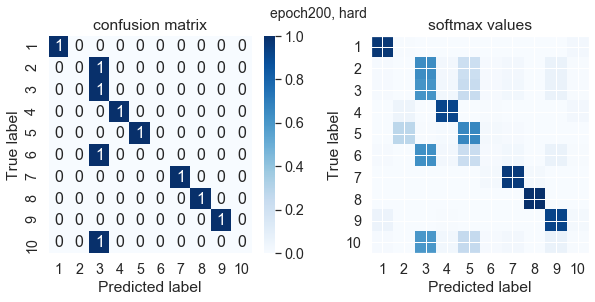

In [74]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-hard-onlyaux/'
output, output2, cfms, cfms_hard, matrices, matrices_hard = \
plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, [0, 1, 200], \
               ratio=0.05, num_patches=1, plot=True, ge=False, total=total, hard=True)

result = [output, output2, cfms, cfms_hard, matrices, matrices_hard]

# with open(dir_path+'result_repro.pickle', 'wb') as handle:
#     pickle.dump((indices, result), handle, protocol=pickle.HIGHEST_PROTOCOL)

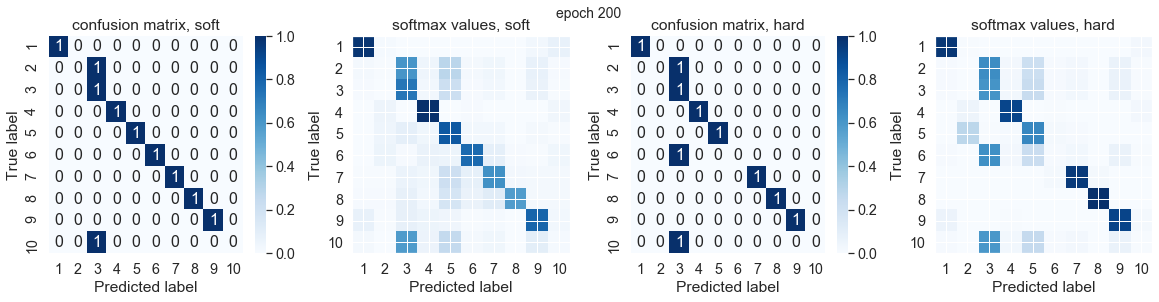

In [95]:
plot_cfm_LogSoftmax2(cfms[2], matrices[2], cfms_hard[2], matrices_hard[2], 'epoch 200')
# plt.savefig('./img/g1572.png', dpi=300)

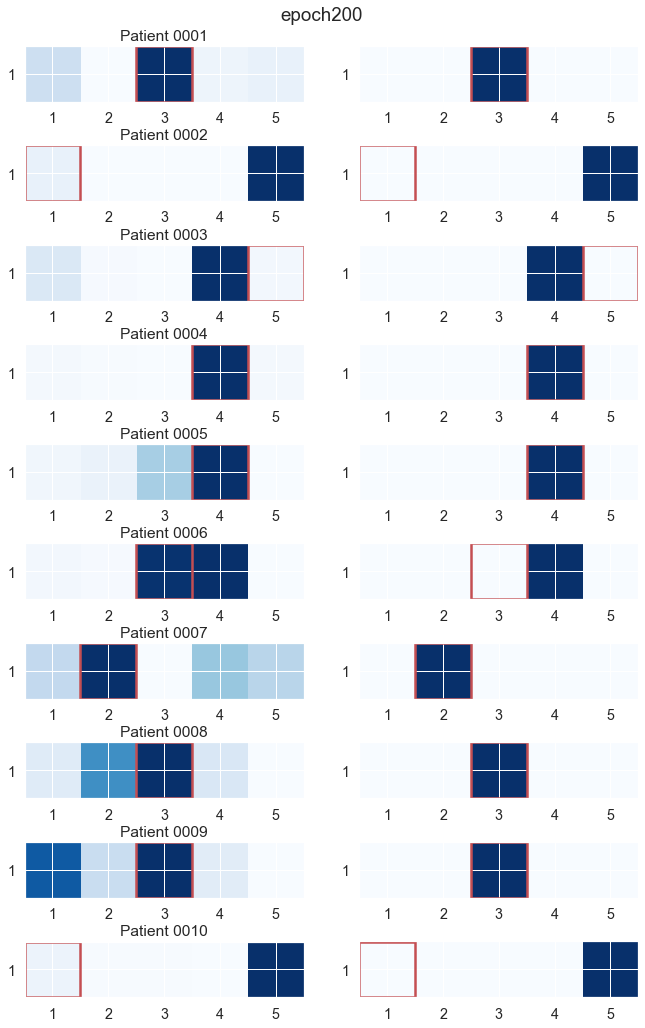

In [96]:
plot_Z([200], output[-10:, :, :], total)
# plt.savefig('./img/g1573.png', dpi=300)

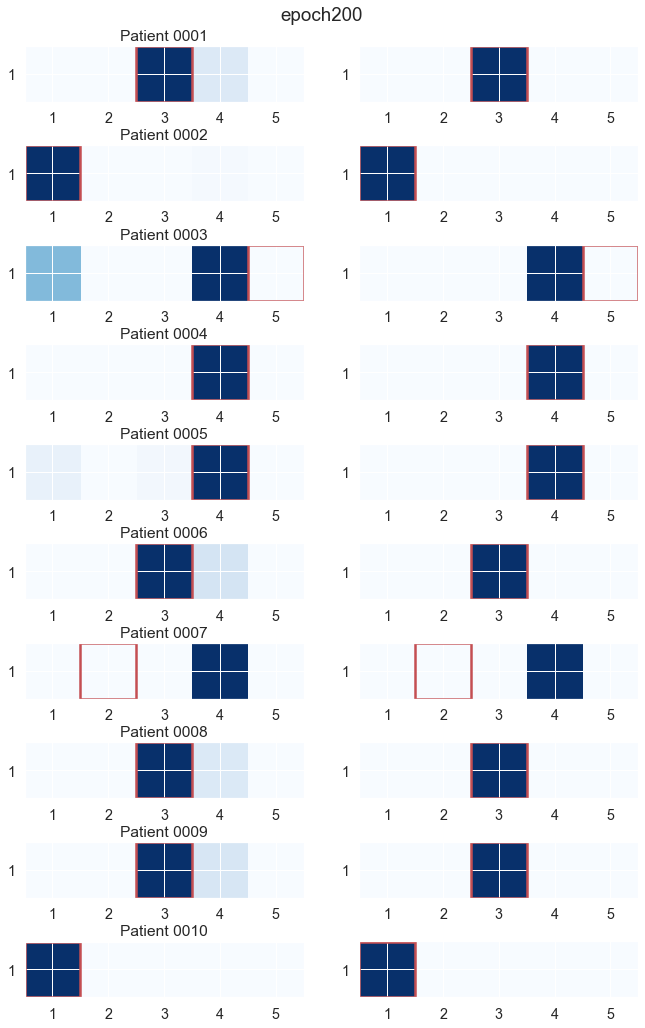

In [97]:
plot_Z([200], output2[-10:, :, :], total)
# plt.savefig('./img/g1574.png', dpi=300)

## Pretrained  graph embedding (max), joint learning, aux loss, hard

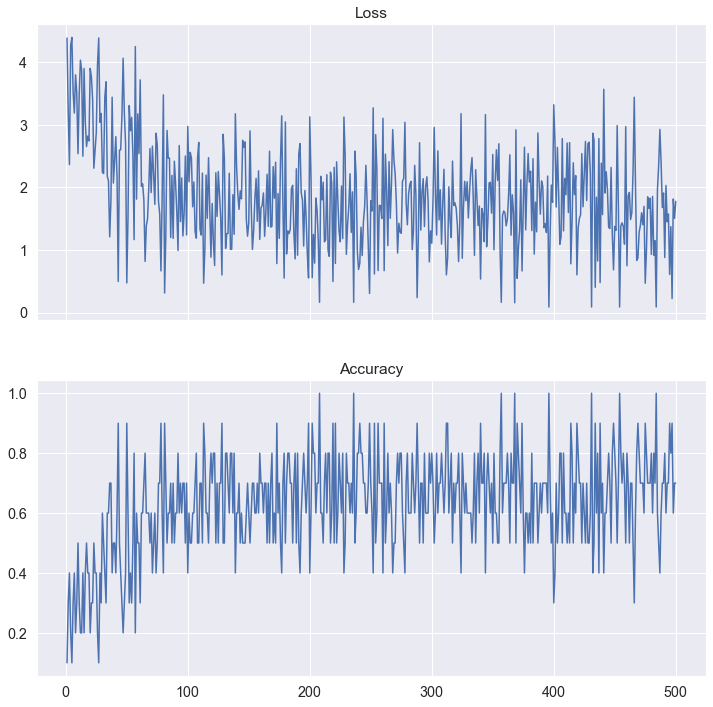

In [79]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-hard-aux/'
plot_loss_acc(dir_path+'log_2021-01-21_02-10.txt')
# plt.savefig('./img/g1581.png', dpi=300)

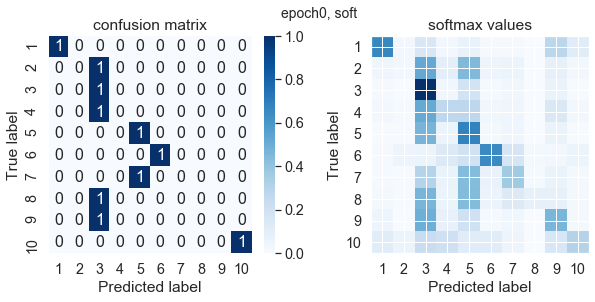

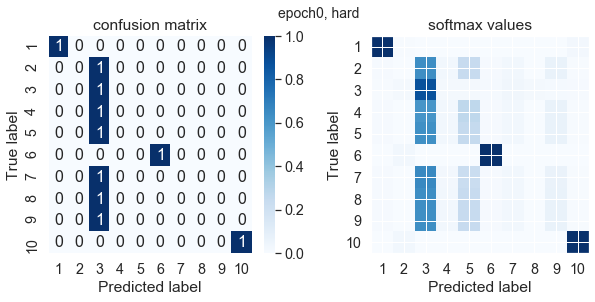

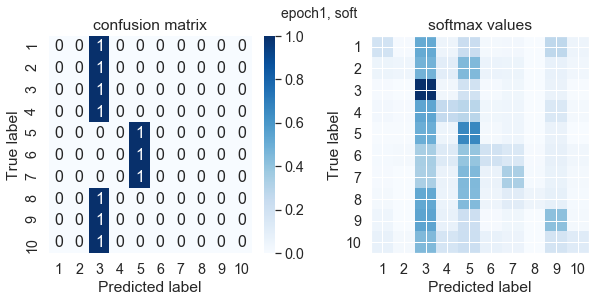

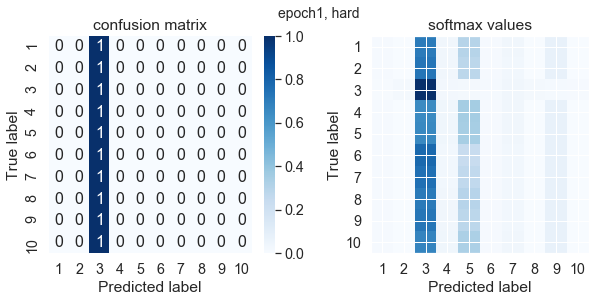

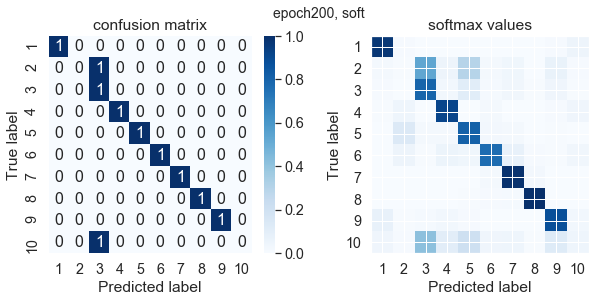

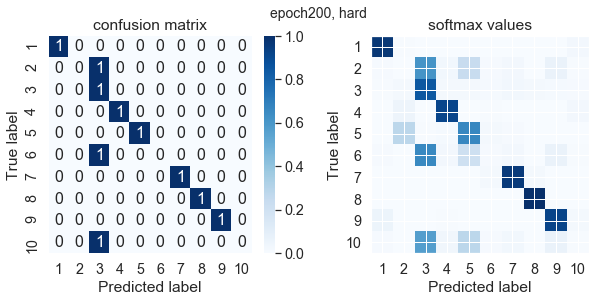

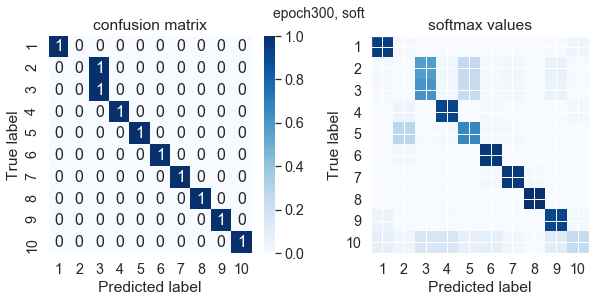

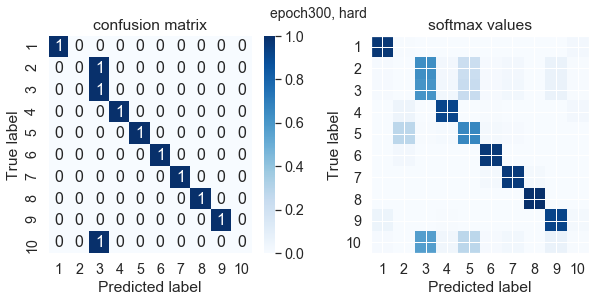

In [103]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel1_5-max-hard-aux/'
output, output2, cfms, cfms_hard, matrices, matrices_hard = \
plot_evolution(dir_path, initial_temp, annealing_rate, lower_bound, [0, 1, 200, 300], \
               ratio=0.05, num_patches=1, plot=True, ge=False, total=total, hard=True)

result = [output, output2, cfms, cfms_hard, matrices, matrices_hard]

# with open(dir_path+'result_repro.pickle', 'wb') as handle:
#     pickle.dump((indices, result), handle, protocol=pickle.HIGHEST_PROTOCOL)

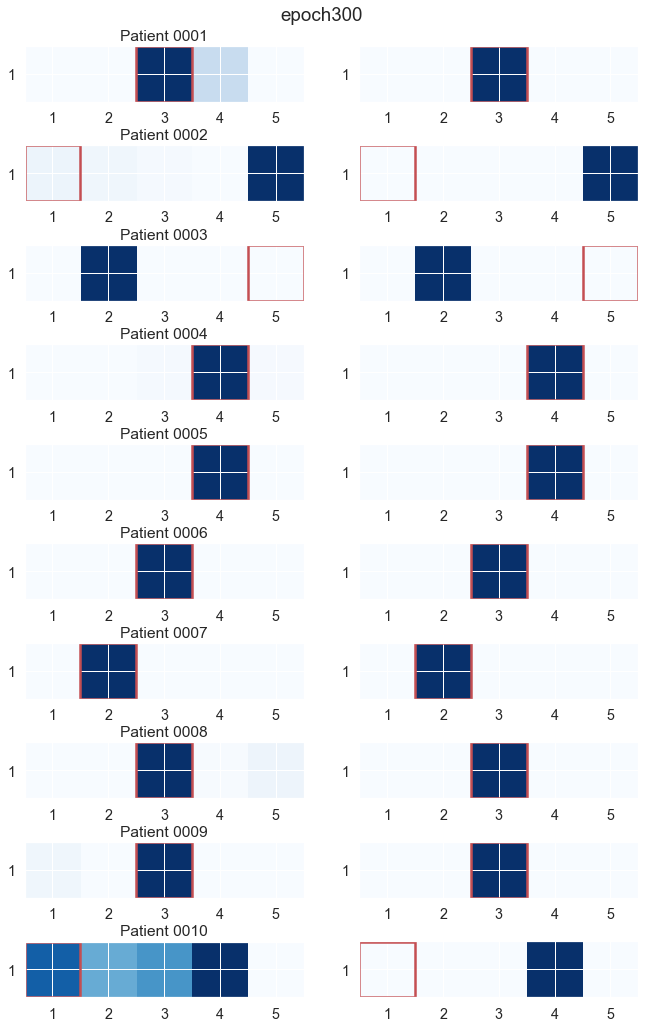

In [105]:
plot_Z([300], output[-10:, :, :], total)
# plt.savefig('./img/g1583.png', dpi=300)

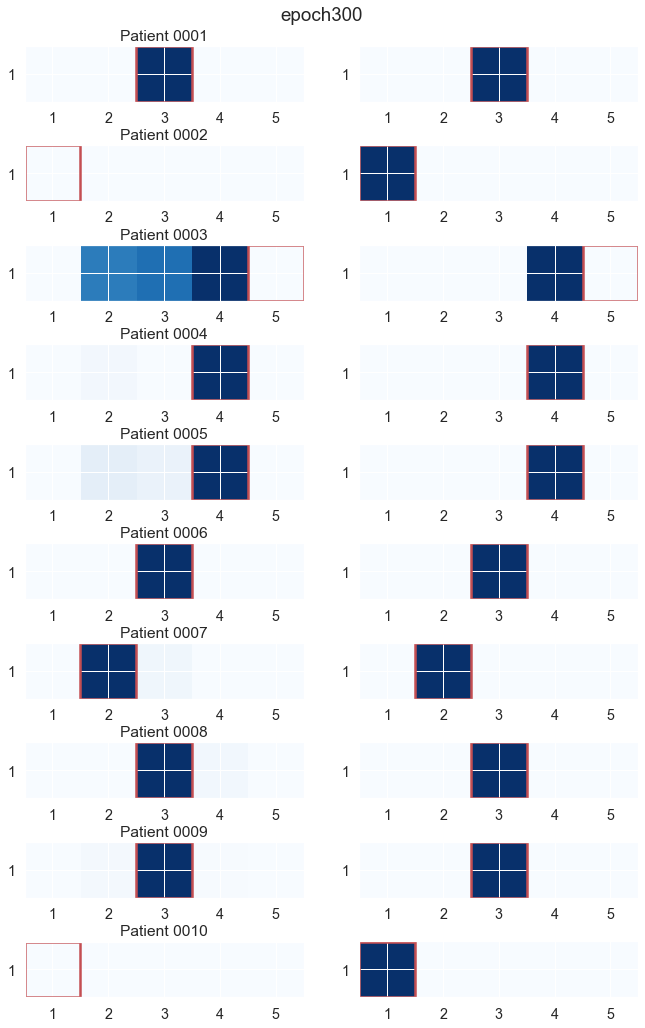

In [102]:
plot_Z([300], output2[-10:, :, :], total)
# plt.savefig('./img/g1584.png', dpi=300)